In [532]:
import os
import sys
import json
import numpy as np
from pathlib import Path
import pydicom
import skimage

# sys.path.append('../../../')
# sys.path.append('../../')

In [534]:
import prepare_data
import label_mapping

In [536]:
root_path = '/export/scratch2/grewal/Data/Projects_DICOM_data/ThreeD/MODIR_data_train_split/'
output_path = './tmp_test/'

# output_path = '/export/scratch3/grewal/Data/segmentation_prepared_data/AMC_dicom_train/'
# output_path = '/export/scratch3/bvdp/segmentation/data/MODIR_data_preprocessed_train_09-04-2020/'
# label_output_path = '/export/scratch3/grewal/Data/segmentation_prepared_data/AMC_dicom_train_labels/'
# label_output_path = '/export/scratch3/bvdp/segmentation/data/MODIR_data_preprocessed_train_09-04-2020_labels/'
# root_path = '/export/scratch3/grewal/Data/__Tijdelijk/'
# output_path = '/export/scratch3/grewal/Data/segmentation_prepared_data/AMC_sigmoid/'
# label_output_path = '/export/scratch3/grewal/Data/segmentation_prepared_data/AMC_sigmoid_labels/'

In [538]:
# bla = '/export/scratch2/grewal/Data/Projects_DICOM_data/ThreeD/MODIR_data_train_split/4266636101_353623177/20130325'
bla = '/export/scratch2/grewal/Data/Projects_DICOM_data/ThreeD/MODIR_data_train_split/3476679937_3399399578'
pp = Path(bla)
dicom_path = str(output_path / pp.relative_to(root_path))
# dicom_path, pp
results = prepare_data.process_dicoms(str(pp), output_directory=dicom_path)

1.2.826.0.1.3680043.2.135.737157.54716028.7.1569622798.265.81


/export/scratch3/bvdp/segmentation/env/lib64/python3.6/site-packages/scipy/ndimage/interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


In [20]:
# list(root_dir.glob('*/*'))

In [458]:
root_dir  = Path(root_path)

dcm_paths = root_dir.glob('**/*dcm')
dcm_base_folders = list(set([dcm_p.parent.parent for dcm_p in dcm_paths]))
print("Number of folders: ", len(dcm_base_folders))

Number of folders:  1009


In [26]:
[folder for folder in dcm_base_folders if "3233" in str(folder)]

[PosixPath('/export/scratch2/grewal/Data/Projects_DICOM_data/ThreeD/MODIR_data_train_split/3131323394_35179856/20130318'),
 PosixPath('/export/scratch2/grewal/Data/Projects_DICOM_data/ThreeD/MODIR_data_train_split/3233114526_1289816699')]

In [541]:
from scipy.ndimage import zoom, interpolation

def process_annotations(annotations, sorted_metadata_list, target_shape, desired_spacing=[0.976562, 0.976562], 
                        desired_slice_thickness=2.5, classes=['background', 'bowel_bag', 'bladder', 'hip', 'rectum']):        
    
    # order in which to layer class annotations in case they overlap
    class_layering = ['background', 'bowel_bag', 'bladder', 'hip', 'rectum']

    uid_to_slice_idx = dict([(meta['uid'], i) for i, meta in enumerate(sorted_metadata_list)])    
        
    meta = sorted_metadata_list[0]
    patientposition = meta['PatientPosition']
    origin = meta['origin'][:2]
    pixelspacing = np.array(meta['PixelSpacing'][:2])
    slice_thickness = meta['SliceThickness']
    new_annotations = []
    
    mask_volume = np.zeros((len(sorted_metadata_list), target_shape[1], target_shape[2]), dtype=np.int)  
    class2idx = dict(zip(classes, range(len(classes))))    
    
    class2layeridx = dict(zip(class_layering, range(len(classes))))
    class_layer_indici = np.array([class2layeridx[class_name] for class_name in classes])


    slice_label_counts = {}
    for item in sorted(annotations, key=lambda x: uid_to_slice_idx.get(x['uid'], -1)):        
        uid = item["uid"]
        slice_idx = uid_to_slice_idx.get(uid, None)
        if slice_idx is None:
            continue

        coords = item["coords"]

        if patientposition=="HFP":
            orientation = np.array([-1, -1])
            coords_pix = orientation*np.array(coords) - orientation*origin  
            coords_pix = coords_pix / pixelspacing
            coords_pix = meta['npixels'] - coords_pix
            zoom_factor = pixelspacing / desired_spacing
            coords_pix = coords_pix * zoom_factor
        else:
            coords_pix = np.array(coords) - origin
            coords_pix = coords_pix / pixelspacing
            zoom_factor = pixelspacing / desired_spacing
            coords_pix = coords_pix * zoom_factor


        label = item["label_name"]
        label_mapped = label_mapping.map_label(label)
        if label_mapped is None:
            continue
        label_idx = class2idx.get(label_mapped)
        if label_idx is None:
            continue
                
        
            
        if label_mapped != 'hip' and slice_label_counts.get(slice_idx, {}).get(label_mapped, 0) > 0:            
            print(f"Already encountered label {label_mapped} for slice {slice_idx}. Skipping")
            print(f"original label: {label}")
            continue
        elif label_mapped == 'hip' and slice_label_counts.get(slice_idx, {}).get(label_mapped, 0) > 1:
            print(f"Already encountered label {label_mapped} twice for slice {slice_idx}. Skipping")
            continue
        
            
        coords_np = coords_pix
        rr, cc = skimage.draw.polygon(coords_np[:,0], coords_np[:,1], shape=(target_shape[1], target_shape[2]))

        # determine whether to overwrite existing annotation label based on predefined ordering 
        # (for example bladder takes precedence bowel bag)
        overwrite_mask = class_layer_indici[mask_volume[slice_idx, cc,rr]] < class_layer_indici[label_idx]        
        rr, cc = rr[overwrite_mask], cc[overwrite_mask]

        mask_volume[slice_idx, cc, rr] = label_idx
        label_counts = slice_label_counts.get(slice_idx, {label_mapped: 0})
        label_counts[label_mapped] = label_counts.get(label_mapped, 0) + 1
        slice_label_counts[slice_idx] = label_counts
    zoom_factor_slice = slice_thickness / desired_slice_thickness
    # only resample slice dimension because we already handle the other resampling ourselves by
    # transforming the coordinates
    resampled = zoom(mask_volume, [zoom_factor_slice, 1, 1], order=0)


    # TMP REMOVE!!
#     resampled = mask_volume
    
    
    encountered_classes = list(set([cat for count_dict in slice_label_counts.values() for cat in count_dict.keys()]))
    
    return resampled, encountered_classes

In [79]:
mask_volume, encountered_classes = process_annotations(
    annotations, sorted_metadata_list, target_shape=volume.shape, 
    desired_slice_thickness=desired_slice_thickness, desired_spacing=desired_spacing)

Already encountered label bowel_bag for slice 75. Skipping
original label: bowel_bag
Already encountered label bowel_bag for slice 76. Skipping
original label: bowel_bag
Already encountered label bowel_bag for slice 77. Skipping
original label: bowel_bag


In [8]:
def visualize_data(volume, mask_volume, output_dir, i=0):
    colors = {0: (1, 0, 0), 1: (1, 0, 1), 2: (0, 1, 0), 3: (0, 0, 1),
                4: (1, 1, 0), 5: (0, 1, 1), 6: (1, 0, 1),
                7: (1, 0.5, 0), 8: (0, 1, 0.5), 9: (0.5, 0, 1),
                10: (0.5, 1, 0), 11: (0, 0.5, 1), 12: (1, 0, 0.5)}
    
#     volume = volume[0]
    n_slices = volume.shape[0]
#     for i in range(n_slices):
    img = volume[i]
    mask = mask_volume[i]
    combined = np.stack((img,)*3, axis=-1)
    opacity = 0.5
    for j in [1,2,3,4]:
        combined[mask == j] = opacity*np.array(colors[j]) + np.stack(((1-opacity)*img[mask == j],)*3, axis=-1)
    combined = np.concatenate((combined, np.stack((img,)*3, axis=-1)), axis=1)    
    return (combined * 255).astype(np.uint8)
    
#         output_path = Path(output_dir) / f"{i}.jpg"
#         output_path.parent.mkdir(exist_ok=True, parents=True)
#         imsave(str(output_path), (combined * 255).astype(np.uint8))

In [94]:
volume.shape, mask_volume.shape

((206, 614, 614), (206, 614, 614))

In [151]:
np_file = np.load('tmp_test/1.2.826.0.1.3680043.2.135.737157.54716028.7.1570625819.343.44.npz')

In [3]:
np_file = np.load('/export/scratch3/bvdp/segmentation/data/MODIR_data_preprocessed_train_23-04-2020/3233114526_1289816699/1.2.826.0.1.3680043.2.135.737157.54716028.7.1570625819.343.44.npz')

In [4]:
volume, mask_volume = np_file['volume'], np_file['mask_volume']

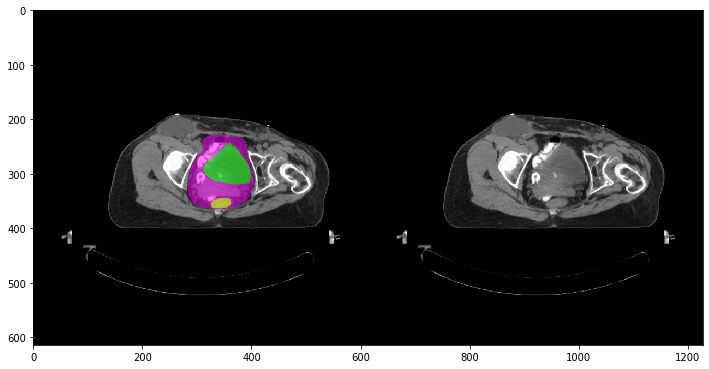

In [25]:
plt.figure(figsize=(12,12))
plt.imshow(visualize_data(volume[0], mask_volume, None, i=91))
# visualize_data(volume, mask_volume, None, i=90)

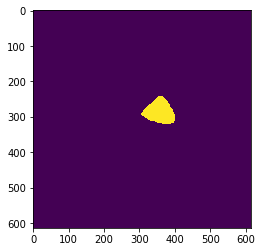

In [6]:
import matplotlib.pyplot as plt
plt.imshow(mask_volume[90] == 2)

In [204]:
metadata

{'SeriesInstanceUID': '1.2.826.0.1.3680043.2.135.737157.54716028.7.1570625819.343.44',
 'uid': '1.2.826.0.1.3680043.2.135.737157.54716028.7.1570625896.343.69',
 'orientation': 'Transverse',
 'origin': [-300.0, -230.0, -187.0],
 'SliceLocation': -187.0,
 'PixelSpacing': ["1.171875", "1.171875"],
 'SliceThickness': 3.0,
 'Modality': 'CT',
 'RescaleIntercept': -1024.0,
 'RescaleSlope': 1.0,
 'PatientPosition': 'HFS',
 'WindowWidth': ["00400", "00400"],
 'WindowCenter': ["00050", "00050"],
 'npixels': (512, 512)}

In [422]:
metadata

{'SeriesInstanceUID': '1.2.826.0.1.3680043.2.135.737157.54716028.7.1570626814.0.75',
 'uid': '1.2.826.0.1.3680043.2.135.737157.54716028.7.1570626879.656.99',
 'orientation': 'Transverse',
 'origin': [-250.0, -250.0, 122.5],
 'SliceLocation': 122.5,
 'PixelSpacing': ["0.976562", "0.976562"],
 'SliceThickness': 2.5,
 'Modality': 'CT',
 'RescaleIntercept': -1024.0,
 'RescaleSlope': 1.0,
 'PatientPosition': 'HFS',
 'WindowWidth': 400.0,
 'WindowCenter': 40.0,
 'npixels': (512, 512)}

In [426]:
annotations_original.keys()

dict_keys([PosixPath('/export/scratch2/grewal/Data/Projects_DICOM_data/ThreeD/MODIR_data_train_split/2477741492_1072758908/1/1.2.826.0.1.3680043.2.135.737157.54716028.7.1570626912.906.58.dcm')])

In [576]:
def match_dicoms_and_annotation_v2(dicom_metadata, annotations):
    print("calling match")
    series_info = {}
    for rt_path, annotation in annotations.items():
        annot_uids = [item["uid"] for item in annotation]
        for series_id, metadata_list in dicom_metadata.items():
            dicom_uids = [meta["uid"] for meta in metadata_list]
            matching_uids = [meta["uid"] for meta in metadata_list if meta["uid"] in annot_uids]
            if len(matching_uids) > 1:
                series_info[series_id] = (metadata_list, annotation)
                print(f'Series id: {series_id}\nmatches:{len(matching_uids)}\nrt_path: {rt_path}')

    return series_info

def match_dicoms_and_annotation_v3(dicom_metadata, annotations):
    print("calling match")
    series_info = {}
    for rt_path, annotation in annotations.items():
        annot_uids = [item["uid"] for item in annotation]
        for series_id, metadata_list in dicom_metadata.items():
            dicom_uids = [meta["uid"] for meta in metadata_list]
            matching_uids = [meta["uid"] for meta in metadata_list if meta["uid"] in annot_uids]
            if len(matching_uids) > 1:
                current_results = series_info.get(series_id, [])
                current_results.append((metadata_list, annotation))
                series_info[series_id] = current_results
                print(f'Series id: {series_id}\nmatches:{len(matching_uids)}\nrt_path: {rt_path}')

    return series_info

In [440]:
rtstruct = pydicom.dcmread('/export/scratch2/grewal/Data/Projects_DICOM_data/ThreeD/MODIR_data_train_split/2477741492_1072758908/1/1.2.826.0.1.3680043.2.135.737157.54716028.7.1570626912.906.58.dcm')
rtstruct = pydicom.dcmread('/export/scratch2/grewal/Data/Projects_DICOM_data/ThreeD/MODIR_data_train_split/3476679937_3399399578/1/')

In [446]:
for label_idx, roi in enumerate(rtstruct.ROIContourSequence):
    print(label_idx, rtstruct.StructureSetROISequence[label_idx].ROIName)

0 anal_canal
1 bladder
2 body
3 bowel_bag
4 ctv
5 gtv-PET
6 hip_left
7 hip_right
8 rectum
9 ptv
10 CouchTop
11 CouchTopDenstOR
12 ptv_5mm
13 origin


In [454]:
# rtstruct.StructureSetROISequence[3]

In [451]:
roi = rtstruct.ROIContourSequence[3]
for cont in roi.ContourSequence:
    print(cont.ContourGeometricType)

CLOSED_PLANAR
CLOSED_PLANAR
CLOSED_PLANAR
CLOSED_PLANAR
CLOSED_PLANAR
CLOSED_PLANAR
CLOSED_PLANAR
CLOSED_PLANAR
CLOSED_PLANAR
CLOSED_PLANAR
CLOSED_PLANAR
CLOSED_PLANAR
CLOSED_PLANAR
CLOSED_PLANAR
CLOSED_PLANAR
CLOSED_PLANAR
CLOSED_PLANAR
CLOSED_PLANAR
CLOSED_PLANAR
CLOSED_PLANAR
CLOSED_PLANAR
CLOSED_PLANAR
CLOSED_PLANAR
CLOSED_PLANAR
CLOSED_PLANAR
CLOSED_PLANAR
CLOSED_PLANAR
CLOSED_PLANAR
CLOSED_PLANAR
CLOSED_PLANAR
CLOSED_PLANAR
CLOSED_PLANAR
CLOSED_PLANAR
CLOSED_PLANAR
CLOSED_PLANAR
CLOSED_PLANAR
CLOSED_PLANAR
CLOSED_PLANAR
CLOSED_PLANAR
CLOSED_PLANAR
CLOSED_PLANAR
CLOSED_PLANAR
CLOSED_PLANAR
CLOSED_PLANAR
CLOSED_PLANAR
CLOSED_PLANAR
CLOSED_PLANAR
CLOSED_PLANAR
CLOSED_PLANAR
CLOSED_PLANAR
CLOSED_PLANAR
CLOSED_PLANAR
CLOSED_PLANAR
CLOSED_PLANAR
CLOSED_PLANAR
CLOSED_PLANAR
CLOSED_PLANAR
CLOSED_PLANAR
CLOSED_PLANAR
CLOSED_PLANAR
CLOSED_PLANAR
CLOSED_PLANAR
CLOSED_PLANAR
CLOSED_PLANAR
CLOSED_PLANAR
CLOSED_PLANAR
CLOSED_PLANAR
CLOSED_PLANAR
CLOSED_PLANAR
CLOSED_PLANAR
CLOSED_PLANAR
CLOSED

In [465]:
# cont

In [765]:
# from prepare_data import extract_info, process_dicom_array, convert_dtypes, process_rtstruct, match_dicoms_and_annotation
from prepare_data import process_volume, match_dicoms_and_annotation, convert_dtypes, extract_info
from prepare_data import load_dicom, process_rtstruct
# from prepare_data import rescale_intensity, apply_ww_wl, normalize_array

    


    
# input_directory = '/export/scratch2/grewal/Data/Projects_DICOM_data/ThreeD/MODIR_data_train_split/3233114526_1289816699'
# input_directory = '/export/scratch2/grewal/Data/Projects_DICOM_data/ThreeD/MODIR_data_train_split/432472126_4123580762/'
# input_directory = '/export/scratch2/grewal/Data/Projects_DICOM_data/ThreeD/MODIR_data_train_split/2477741492_1072758908/'
# input_directory = '/export/scratch2/grewal/Data/Projects_DICOM_data/ThreeD/MODIR_data_train_split/3476679937_3399399578'
# input_directory = '/export/scratch2/grewal/Data/Projects_DICOM_data/ThreeD/MODIR_data_train_split/3450012419_1594035157'
input_directory = '/export/scratch2/grewal/Data/Projects_DICOM_data/ThreeD/MODIR_data_train_split/2162753007_1395134758/'
output_directory= 'tmp_test'
orientation="Transverse"
modality="CT"
desired_spacing=[0.976562, 0.976562]
# desired_spacing=[1.171875, 1.171875]
desired_slice_thickness=2.5
# desired_slice_thickness=3.0


root_dir  = Path(input_directory)
output_dir  = Path(output_directory)
dicom_metadata = {}
dicom_imagedata = {}
annotations = {}
for i, pp in enumerate(root_dir.glob('*/*.dcm')):
#     print(pp)
# for i, pp in enumerate(root_dir.glob('**/*.dcm')):
    if not pp.is_file():
        continue        
    im = pydicom.dcmread(str(pp))
    metadata, status = extract_info(im)
    if metadata['Modality'] == 'RTSTRUCT':
        print(pp)
        annotations[pp] = process_rtstruct(im)
        continue

    if status and metadata["Modality"] == modality and metadata["orientation"] == orientation:
        metadata = convert_dtypes(metadata)
        series_id = metadata["SeriesInstanceUID"]
        arr = load_dicom(im)
        if arr is None:
            continue            

        metadata['npixels'] = arr.shape

        series_results = dicom_metadata.get(series_id, [])
        series_results.append(metadata)
        dicom_metadata[series_id] = series_results

        series_images = dicom_imagedata.get(series_id, [])
        series_images.append(arr)
        dicom_imagedata[series_id] = series_images

series_info = match_dicoms_and_annotation_v2(dicom_metadata, annotations)

# take first one assuming in most cases there is only one match per study. Maybe extend to all matches?

if len(series_info) == 0:
    print("No matches between dicoms and annotations")
    sys.exit()
series_id = list(series_info.keys())[0]
print(series_id)
serie_info = series_info[series_id]
annotations_original = annotations
metadata_list, annotations = serie_info
metadata = metadata_list[0]
sorted_indici = sorted(zip(range(len(metadata_list)), metadata_list), key=lambda x: x[1]['SliceLocation'])
sorted_indici = [idx for idx, metadata in sorted_indici]
sorted_images = [dicom_imagedata[series_id][i] for i in sorted_indici]
volume = np.stack(sorted_images)
print(volume.shape)
volume = process_volume(
    volume, metadata, desired_slice_thickness=desired_slice_thickness, desired_spacing=desired_spacing)
print(volume.shape)
sorted_metadata_list = [metadata_list[i] for i in sorted_indici]
mask_volume, encountered_classes = process_annotations(
    annotations, sorted_metadata_list, target_shape=volume.shape, 
    desired_slice_thickness=desired_slice_thickness, desired_spacing=desired_spacing)


# output_dir.mkdir(exist_ok=True, parents=True)


# np.savez_compressed(str(output_dir / f'{series_id}.npz'), volume=volume, mask_volume=mask_volume)

# #     return volume, mask_volume, annotations
# output_keys = [
#     'SeriesInstanceUID', 'orientation', 'origin', 'PixelSpacing', 'SliceThickness', 'Modality', 
#     'RescaleIntercept', 'RescaleSlope', 'PatientPosition', 'WindowWidth', 'WindowCenter', 'npixels'
# ]
# metadata_filtered = {k:v for k,v in metadata.items() if k in output_keys}
# meta_result = {
#     **metadata_filtered, 'labels': encountered_classes, 'input_directory': input_directory, 
#     'output_directory': output_directory, 'desired_pixel_spacing': desired_spacing, 
#     'desired_slice_thickness': desired_slice_thickness}
# with open(str(output_dir / f'{series_id}.json'), 'w') as meta_output:
#     meta_output.write(json.dumps(meta_result))


/export/scratch2/grewal/Data/Projects_DICOM_data/ThreeD/MODIR_data_train_split/2162753007_1395134758/1/1.2.826.0.1.3680043.2.135.737157.54716028.7.1568710531.31.21.dcm
/export/scratch2/grewal/Data/Projects_DICOM_data/ThreeD/MODIR_data_train_split/2162753007_1395134758/1/1.2.826.0.1.3680043.2.135.737157.54716028.7.1570116574.62.73.dcm
/export/scratch2/grewal/Data/Projects_DICOM_data/ThreeD/MODIR_data_train_split/2162753007_1395134758/1/1.2.826.0.1.3680043.2.135.737157.54716028.7.1568710492.703.64.dcm
/export/scratch2/grewal/Data/Projects_DICOM_data/ThreeD/MODIR_data_train_split/2162753007_1395134758/1/1.2.826.0.1.3680043.2.135.737157.54716028.7.1570116517.250.97.dcm
/export/scratch2/grewal/Data/Projects_DICOM_data/ThreeD/MODIR_data_train_split/2162753007_1395134758/1/1.2.826.0.1.3680043.2.135.737157.54716028.7.1568710821.531.0.dcm
/export/scratch2/grewal/Data/Projects_DICOM_data/ThreeD/MODIR_data_train_split/2162753007_1395134758/1/1.2.826.0.1.3680043.2.135.737157.54716028.7.1568710658.

In [770]:
volume.shape

(51, 614, 614)

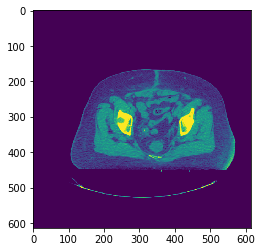

In [777]:
plt.imshow(volume[5])

In [778]:
bla = match_dicoms_and_annotation_v3(dicom_metadata, annotations_original)
# len(bla)

calling match
Series id: 1.2.826.0.1.3680043.2.135.737157.54716028.7.1568710501.921.69
matches:24
rt_path: /export/scratch2/grewal/Data/Projects_DICOM_data/ThreeD/MODIR_data_train_split/2162753007_1395134758/1/1.2.826.0.1.3680043.2.135.737157.54716028.7.1568710531.31.21.dcm
Series id: 1.2.826.0.1.3680043.2.135.737157.54716028.7.1570116536.828.1
matches:107
rt_path: /export/scratch2/grewal/Data/Projects_DICOM_data/ThreeD/MODIR_data_train_split/2162753007_1395134758/1/1.2.826.0.1.3680043.2.135.737157.54716028.7.1570116574.62.73.dcm
Series id: 1.2.826.0.1.3680043.2.135.737157.54716028.7.1568710461.140.10
matches:51
rt_path: /export/scratch2/grewal/Data/Projects_DICOM_data/ThreeD/MODIR_data_train_split/2162753007_1395134758/1/1.2.826.0.1.3680043.2.135.737157.54716028.7.1568710492.703.64.dcm
Series id: 1.2.826.0.1.3680043.2.135.737157.54716028.7.1570116505.484.45
matches:24
rt_path: /export/scratch2/grewal/Data/Projects_DICOM_data/ThreeD/MODIR_data_train_split/2162753007_1395134758/1/1.2.82

In [815]:
series_info.keys()
series_info['1.2.826.0.1.3680043.2.135.737157.54716028.7.1568710501.921.69']

dict_keys(['1.2.826.0.1.3680043.2.135.737157.54716028.7.1568710501.921.69', '1.2.826.0.1.3680043.2.135.737157.54716028.7.1570116536.828.1', '1.2.826.0.1.3680043.2.135.737157.54716028.7.1568710461.140.10', '1.2.826.0.1.3680043.2.135.737157.54716028.7.1570116505.484.45', '1.2.826.0.1.3680043.2.135.737157.54716028.7.1568710561.406.25', '1.2.826.0.1.3680043.2.135.737157.54716028.7.1570116491.250.86'])

In [867]:
series_info = bla
series_id = list(series_info.keys())[4]
print(series_id)
serie_info = series_info[series_id][0]
metadata_list, annotations = serie_info
metadata = metadata_list[0]

1.2.826.0.1.3680043.2.135.737157.54716028.7.1568710561.406.25


In [868]:
sorted_indici = sorted(zip(range(len(metadata_list)), metadata_list), key=lambda x: x[1]['SliceLocation'])
sorted_indici = [idx for idx, metadata in sorted_indici]
sorted_images = [dicom_imagedata[series_id][i] for i in sorted_indici]
volume = np.stack(sorted_images)
volume = process_volume(
    volume, metadata, desired_slice_thickness=desired_slice_thickness, desired_spacing=desired_spacing)

sorted_metadata_list = [metadata_list[i] for i in sorted_indici]
mask_volume, encountered_classes = process_annotations(
    annotations, sorted_metadata_list, target_shape=volume.shape, 
    desired_slice_thickness=desired_slice_thickness, desired_spacing=desired_spacing)

mask_volume.shape, volume.shape

i: 0
min coords before: [-5.713    74.267998]
else
i: 1
min coords before: [-5.713    72.998001]
else
i: 2
min coords before: [-5.713    72.998001]
else
i: 3
min coords before: [-6.982    71.727997]
else
i: 4
min coords before: [-5.713    69.189003]
else
i: 5
min coords before: [-4.443    65.380997]
else
i: 6
min coords before: [-5.713 57.764]
else
i: 7
min coords before: [-8.252    52.685001]
else
i: 8
min coords before: [-8.252 51.416]
else
i: 9
min coords before: [-8.252 50.146]
else
i: 10
min coords before: [-8.252    48.876999]
else
i: 11
min coords before: [-9.522    46.338001]
else
i: 12
min coords before: [-9.522 43.799]
else
i: 13
min coords before: [-9.522    39.990002]
else
i: 14
min coords before: [-8.252    39.990002]
else
min coords after: [324.35011807 373.74995341]
target shape: (666, 666)
i: 15
min coords before: [-8.252    38.721001]
else
min coords after: [324.35011807 372.45049572]
target shape: (666, 666)
i: 16
min coords before: [-8.252    36.181999]
else
min coor

i: 95
min coords before: [-51.416    -62.841999]
else
min coords after: [280.15015944 268.44993047]
target shape: (666, 666)
i: 96
min coords before: [-61.571999 -83.153999]
else
min coords after: [269.75041114 247.65043182]
target shape: (666, 666)
i: 97
min coords before: [-14.6       55.224998]
else
min coords after: [317.84976274 389.3505973 ]
target shape: (666, 666)
i: 98
min coords before: [-50.146999 -60.303001]
else
min coords after: [281.44961713 271.04986575]
target shape: (666, 666)
i: 99
min coords before: [-62.841999 -83.153999]
else
min coords after: [268.44993047 247.65043182]
target shape: (666, 666)
i: 100
min coords before: [-12.061  57.764]
else
min coords after: [320.44970007 391.95053668]
target shape: (666, 666)
i: 101
min coords before: [-50.146999 -59.033001]
else
min coords after: [281.44961713 272.35034642]
target shape: (666, 666)
i: 102
min coords before: [-64.111    -83.153999]
else
min coords after: [267.15047278 247.65043182]
target shape: (666, 666)
i: 

i: 161
min coords before: [-141.552994 -118.700996]
else
min coords after: [187.84983032 211.25028826]
target shape: (666, 666)
i: 162
min coords before: [-142.822006 -118.700996]
else
min coords after: [186.55036137 211.25028826]
target shape: (666, 666)
i: 163
min coords before: [-142.822006 -119.971001]
else
min coords after: [186.55036137 209.94980247]
target shape: (666, 666)
i: 164
min coords before: [-142.822006 -121.239998]
else
min coords after: [186.55036137 208.65034888]
target shape: (666, 666)
i: 165
min coords before: [-144.091995 -122.510002]
else
min coords after: [185.24989197 207.34986412]
target shape: (666, 666)


((171, 666, 666), (171, 666, 666))

In [863]:
# series_info[series_id]

In [864]:
mask_volume_tmp = mask_volume.copy()
volume_tmp = volume.copy()

In [866]:
mask_volume.shape, volume.shape

((171, 666, 666), (171, 666, 666))

In [872]:
# (volume == volume_tmp).all()

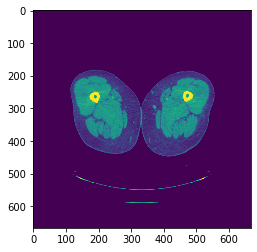

In [869]:
plt.imshow(volume[0])

In [703]:
# annot = [annot for annot in annotations if annot['uid'] == '1.2.826.0.1.3680043.2.135.737157.54716028.7.1569559497.546.53'][0]
annot = annotations[0]

In [633]:
# pd.Series([annot['label_name'] for annots in annotations_original.values() for annot in annots]).value_counts()

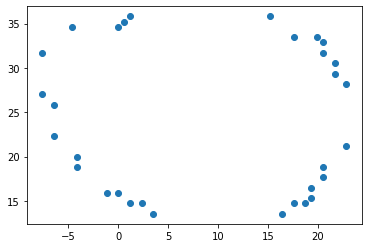

In [704]:
plt.scatter(np.array(annot['coords'])[:,0], np.array(annot['coords'])[:,1])

In [709]:
meta

{'SeriesInstanceUID': '1.2.826.0.1.3680043.2.135.737157.54716028.7.1569622798.265.81',
 'uid': '1.2.826.0.1.3680043.2.135.737157.54716028.7.1569622797.437.77',
 'orientation': 'Transverse',
 'origin': [-300.0, 245.0, -468.5],
 'SliceLocation': -468.5,
 'PixelSpacing': ["1.171875", "1.171875"],
 'SliceThickness': 3.0,
 'Modality': 'CT',
 'RescaleIntercept': -1024.0,
 'RescaleSlope': 1.0,
 'PatientPosition': 'HFP',
 'WindowWidth': ["00400", "00400"],
 'WindowCenter': ["00050", "00050"],
 'npixels': (512, 512)}

In [721]:
# annot

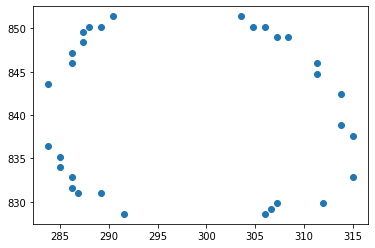

In [723]:
desired_spacing=[0.976562, 0.976562], 
desired_slice_thickness=2.5
meta = sorted_metadata_list[0]
# coords = annotations[40]['coords']
coords = annot['coords']
origin = metadata_list[0]['origin'][:2]

orientation = np.array([-1, -1])
coords_pix = orientation*np.array(coords) - orientation*origin  
coords_pix = np.array(coords) - origin  
coords_pix = coords_pix / pixelspacing
coords_pix = meta['npixels'] - coords_pix
zoom_factor = pixelspacing / desired_spacing
coords_pix = coords_pix * zoom_factor


# coords_pix = np.array(coords) - origin
# coords_pix = coords_pix / pixelspacing
# zoom_factor = pixelspacing / desired_spacing
# coords_pix = coords_pix * zoom_factor

plt.scatter(coords_pix[:,0], coords_pix[:,1])

In [710]:
coords_np = coords_pix
rr, cc = skimage.draw.polygon(coords_np[:,0], coords_np[:,1], shape=(614, 614))

In [711]:
rr

array([], dtype=int64)

In [636]:
metadata_list[0]

{'SeriesInstanceUID': '1.2.826.0.1.3680043.2.135.737157.54716028.7.1569559442.546.2',
 'uid': '1.2.826.0.1.3680043.2.135.737157.54716028.7.1569559548.812.99',
 'orientation': 'Transverse',
 'origin': [-300.0, -230.0, -120.5],
 'SliceLocation': -120.5,
 'PixelSpacing': ["1.171875", "1.171875"],
 'SliceThickness': 3.0,
 'Modality': 'CT',
 'RescaleIntercept': -1024.0,
 'RescaleSlope': 1.0,
 'PatientPosition': 'HFS',
 'WindowWidth': ["00400", "00400"],
 'WindowCenter': ["00050", "00050"],
 'npixels': (512, 512)}

In [567]:
sorted_metadata_list[0]['origin'][:2]

[-300.0, 245.0]

In [653]:
mask_volume.shape

(173, 614, 614)

In [295]:
# im = pydicom.dcmread('/export/scratch2/grewal/Data/Projects_DICOM_data/ThreeD/MODIR_data_train_split/3233114526_1289816699/1/1.2.826.0.1.3680043.2.135.737157.54716028.7.1570625928.171.17.dcm')
# im = pydicom.dcmread('/export/scratch2/grewal/Data/Projects_DICOM_data/ThreeD/MODIR_data_train_split/3233114526_1289816699/1/1.2.826.0.1.3680043.2.135.737157.54716028.7.1570625472.625.25.dcm')

In [686]:
coords_pix.max(axis=0)

array([974.39998689, 919.20021258])

In [695]:
def process_annotations(annotations, sorted_metadata_list, target_shape, desired_spacing=[0.976562, 0.976562], 
                        desired_slice_thickness=2.5, classes=['background', 'bowel_bag', 'bladder', 'hip', 'rectum']):        
    
    # order in which to layer class annotations in case they overlap
    class_layering = ['background', 'bowel_bag', 'bladder', 'hip', 'rectum']

    uid_to_slice_idx = dict([(meta['uid'], i) for i, meta in enumerate(sorted_metadata_list)])    
        
    meta = sorted_metadata_list[0]
    patientposition = meta['PatientPosition']
    origin = meta['origin'][:2]
    pixelspacing = np.array(meta['PixelSpacing'][:2])
    slice_thickness = meta['SliceThickness']
    new_annotations = []
    
    mask_volume = np.zeros((len(sorted_metadata_list), target_shape[1], target_shape[2]), dtype=np.int)  
    class2idx = dict(zip(classes, range(len(classes))))    
    
    class2layeridx = dict(zip(class_layering, range(len(classes))))
    class_layer_indici = np.array([class2layeridx[class_name] for class_name in classes])


    slice_label_counts = {}
    i = 0
    for item in sorted(annotations, key=lambda x: uid_to_slice_idx.get(x['uid'], -1)):    
        print(f'i: {i}')
        i += 1
        uid = item["uid"]
        slice_idx = uid_to_slice_idx.get(uid, None)
        if slice_idx is None:
            continue

        coords = item["coords"]
        print(f"min coords before: {np.array(coords).min(axis=0)}")
        if patientposition=="HFP":
            print('if')
            orientation = np.array([-1, -1])
            coords_pix = orientation*np.array(coords) - orientation*origin  
            coords_pix = coords_pix / pixelspacing
            coords_pix = meta['npixels'] - coords_pix
            zoom_factor = pixelspacing / desired_spacing
            coords_pix = coords_pix * zoom_factor
        else:
            print('else')
            coords_pix = np.array(coords) - origin
            coords_pix = coords_pix / pixelspacing
            zoom_factor = pixelspacing / desired_spacing
            coords_pix = coords_pix * zoom_factor


        label = item["label_name"]
        label_mapped = label_mapping.map_label(label)
#         print(slice_idx, label, label_mapped)
        if label_mapped is None:
            continue
        label_idx = class2idx.get(label_mapped)
        if label_idx is None:
            continue
                
        
            
#         if label_mapped != 'hip' and slice_label_counts.get(slice_idx, {}).get(label_mapped, 0) > 0:            
#             print(f"Already encountered label {label_mapped} for slice {slice_idx}. Skipping")
#             print(f"original label: {label}")
#             continue
#         elif label_mapped == 'hip' and slice_label_counts.get(slice_idx, {}).get(label_mapped, 0) > 1:
#             print(f"Already encountered label {label_mapped} twice for slice {slice_idx}. Skipping")
#             continue
        
        print(f"min coords after: {coords_pix.min(axis=0)}")
        print(f"target shape: {target_shape[1], target_shape[2]}")
        coords_np = coords_pix
        rr, cc = skimage.draw.polygon(coords_np[:,0], coords_np[:,1], shape=(target_shape[1], target_shape[2]))

        # determine whether to overwrite existing annotation label based on predefined ordering 
        # (for example bladder takes precedence bowel bag)
        overwrite_mask = class_layer_indici[mask_volume[slice_idx, cc,rr]] < class_layer_indici[label_idx]        
        rr, cc = rr[overwrite_mask], cc[overwrite_mask]

        mask_volume[slice_idx, cc, rr] = label_idx
        label_counts = slice_label_counts.get(slice_idx, {label_mapped: 0})
        label_counts[label_mapped] = label_counts.get(label_mapped, 0) + 1
        slice_label_counts[slice_idx] = label_counts
    zoom_factor_slice = slice_thickness / desired_slice_thickness
    # only resample slice dimension because we already handle the other resampling ourselves by
    # transforming the coordinates
    resampled = zoom(mask_volume, [zoom_factor_slice, 1, 1], order=0)


    # TMP REMOVE!!
#     resampled = mask_volume
    
    
    encountered_classes = list(set([cat for count_dict in slice_label_counts.values() for cat in count_dict.keys()]))
    
    return resampled, encountered_classes

In [517]:
desired_spacing_tmp = desired_spacing
desired_slice_thickness_tmp = desired_slice_thickness

In [528]:
slice_thickness

3.0

In [529]:
uid_to_slice_idx = dict([(meta['uid'], i) for i, meta in enumerate(sorted_metadata_list)])    
meta = sorted_metadata_list[0]
patientposition = meta['PatientPosition']
origin = meta['origin'][:2]
pixelspacing = np.array(meta['PixelSpacing'][:2])
slice_thickness = meta['SliceThickness']

desired_spacing = pixelspacing
desired_slice_thickness = slice_thickness

inspect_results = {}

for item in sorted(annotations, key=lambda x: uid_to_slice_idx.get(x['uid'], -1)):
    uid = item["uid"]
    slice_idx = uid_to_slice_idx.get(uid, None)
    if slice_idx is None:
        continue

    coords = item["coords"]

    if patientposition=="HFP":
        orientation = np.array([-1, -1])
        coords_pix = orientation*np.array(coords) - orientation*origin  
        coords_pix = coords_pix / pixelspacing
        coords_pix = meta['npixels'] - coords_pix
        zoom_factor = pixelspacing / desired_spacing
        coords_pix = coords_pix * zoom_factor
    else:
        coords_pix = np.array(coords) - origin
        coords_pix = coords_pix / pixelspacing
        zoom_factor = pixelspacing / desired_spacing
        coords_pix = coords_pix * zoom_factor


    label = item["label_name"]
    label_mapped = label_mapping.map_label(label)    
    inspect_result = inspect_results.get((label_mapped, slice_idx), [])
    inspect_result = inspect_result + [coords_pix]
    inspect_results[(label_mapped, slice_idx)] = inspect_result
#     if slice_idx == 75 and label_mapped == 'bowel_bag':
#         inspect_results.append(coords_pix)
#         print(slice_idx, label, label_mapped)

In [530]:
# results_weird = {k: res for k, res in inspect_results.items() if len(res) > 1 and k[0] != "hip"}
results_weird = {k: res for k, res in list(inspect_results.items())[:20]}
# results_weird

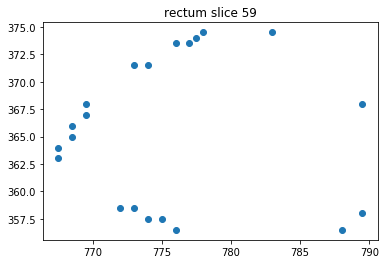

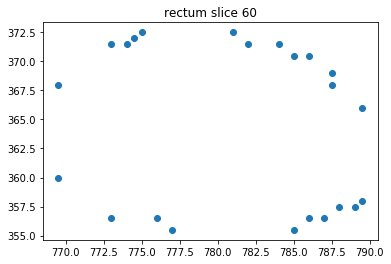

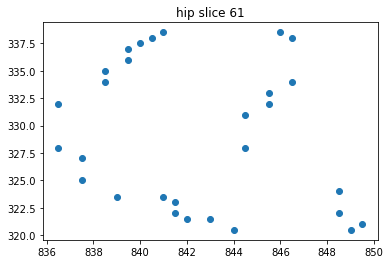

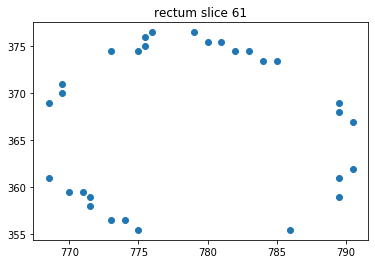

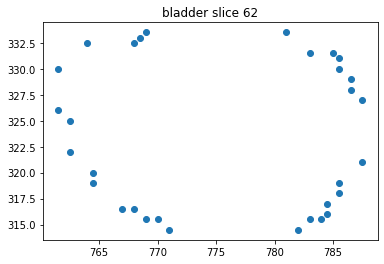

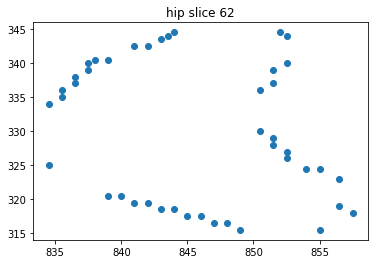

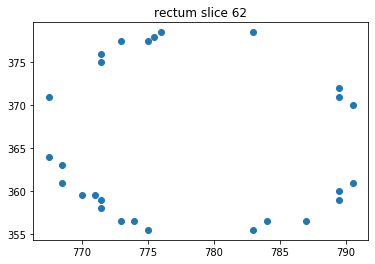

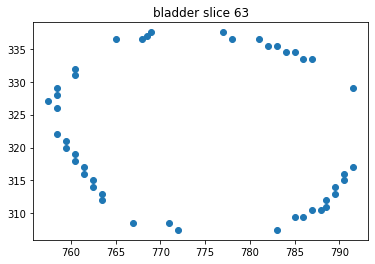

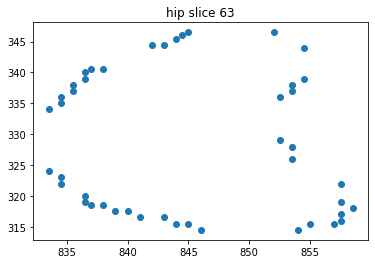

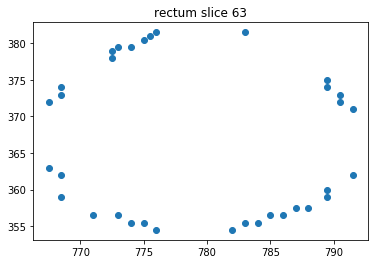

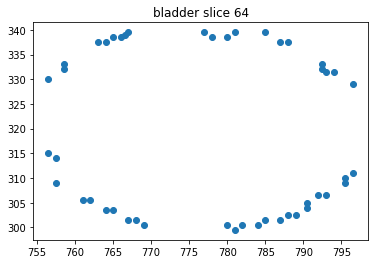

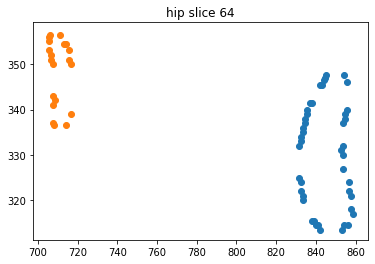

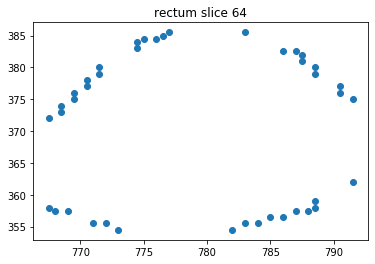

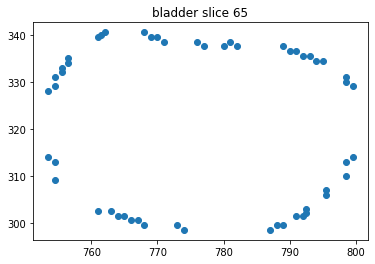

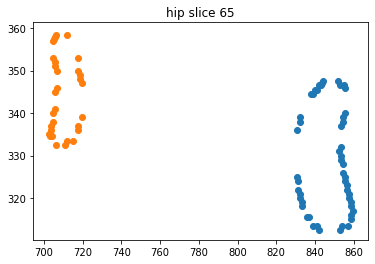

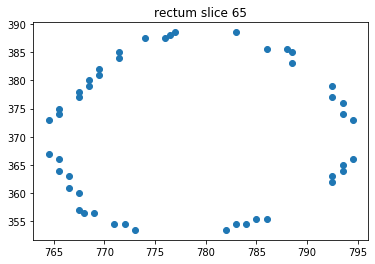

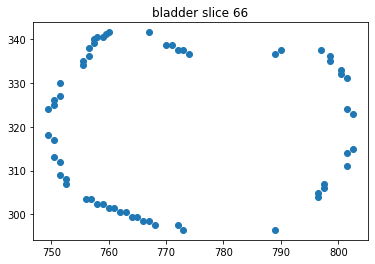

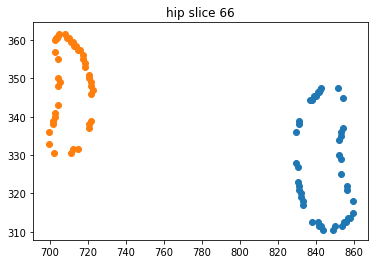

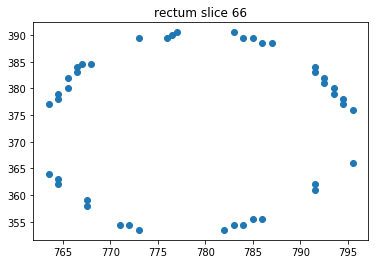

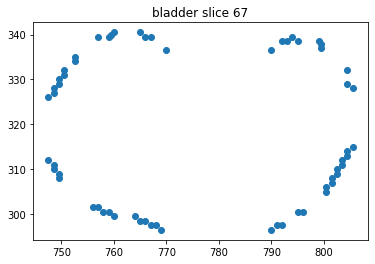

In [531]:
for (label_name, slice_idx), results in results_weird.items():
# for (label_name, slice_idx), results in inspect_results.items():
    fig, ax = plt.subplots()
    for inspect_result in results:
        ax.scatter(inspect_result[:,0], inspect_result[:,1])
        ax.set_title(f'{label_name} slice {slice_idx}')
# ax.scatter(inspect_results[1][:,0], inspect_results[1][:,1])
# ax.scatter(inspect_results[1][:,0], inspect_results[1][:,1])

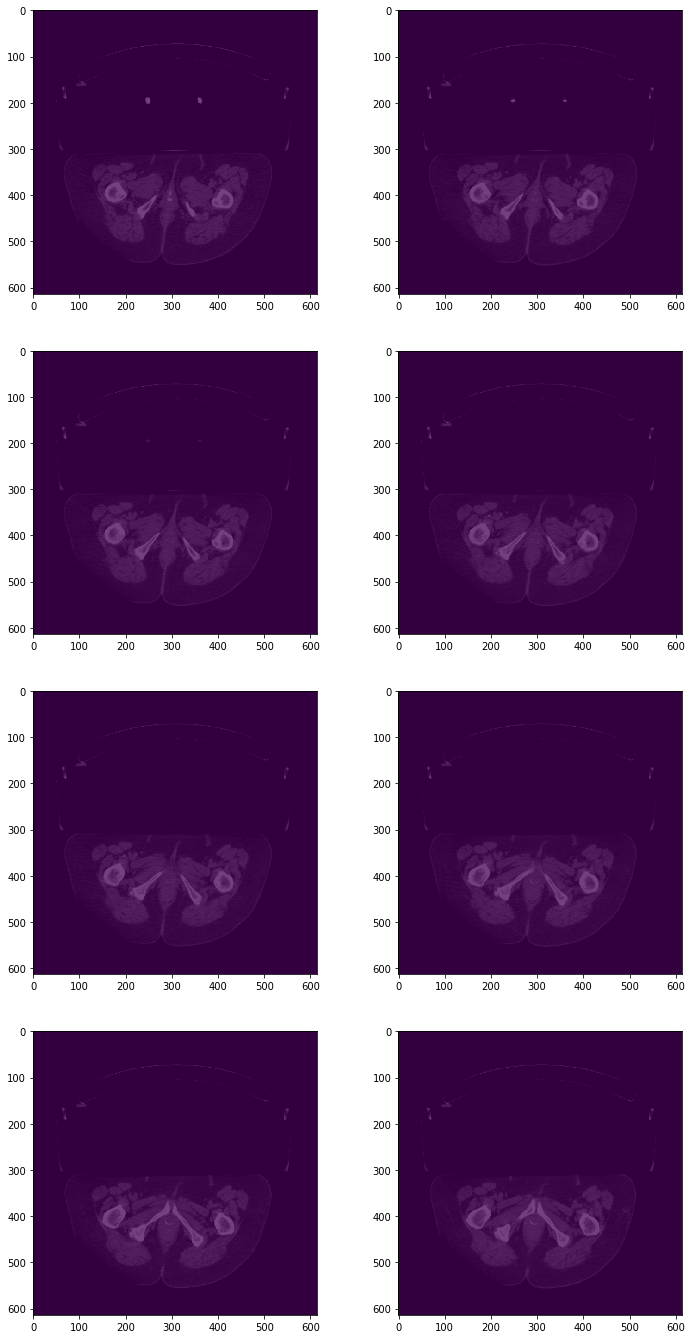

In [511]:
ncols = 2
from_slice=59
to_slice=67
nrows = int(math.ceil((to_slice-from_slice) / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(12,6*nrows))

for i, slice_i in enumerate(range(from_slice, to_slice)):
    ax = axes.ravel()[i]
    ax.imshow(volume[slice_i, :,:], cmap='gray')
    ax.imshow(mask_volume[slice_i,:,:], alpha=0.75)

/export/scratch2/grewal/Data/Projects_DICOM_data/ThreeD/MODIR_data_train_split/2477741492_1072758908/


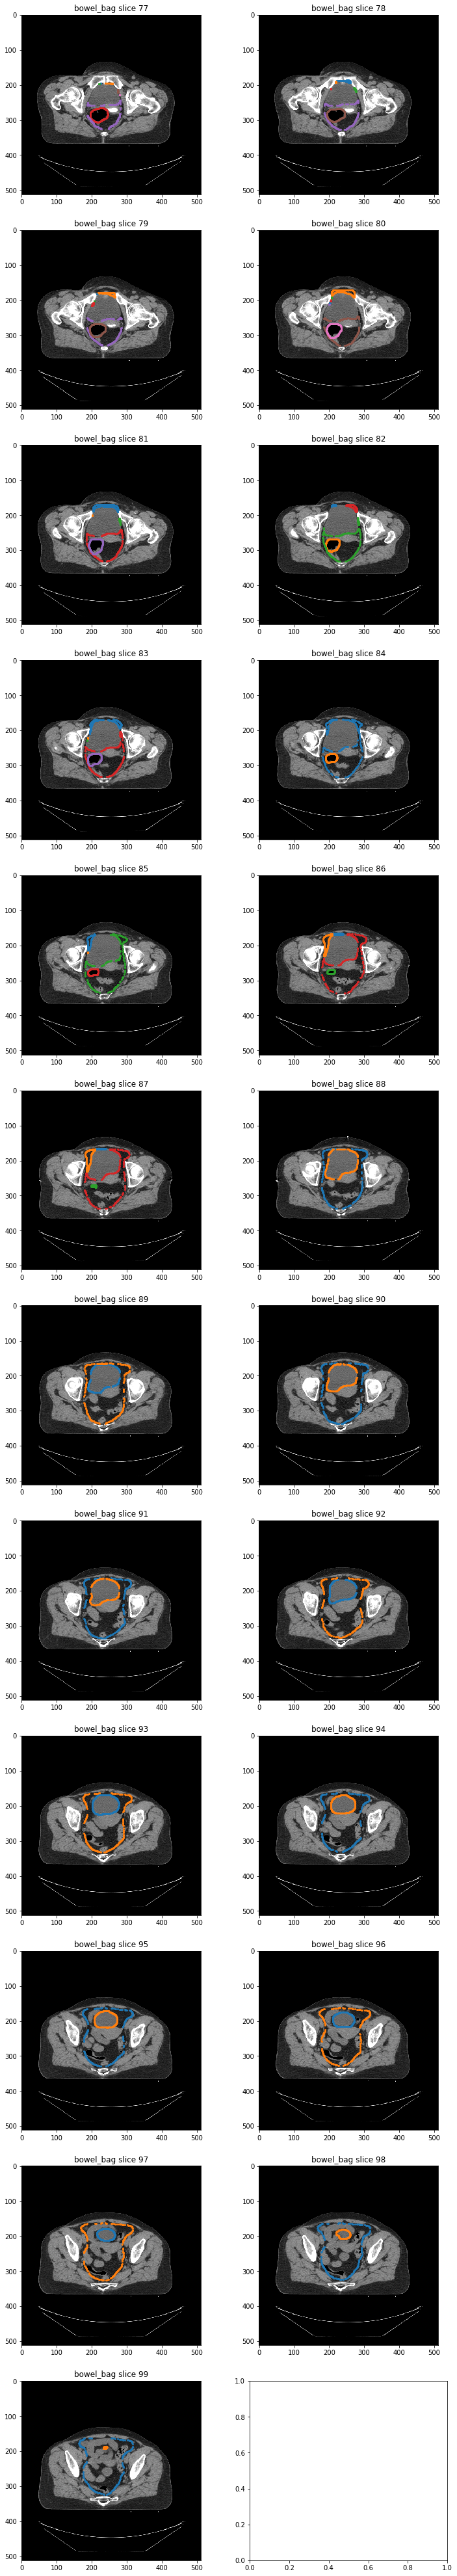

In [464]:
ncols = 2
nrows = int(np.ceil(len(results_weird) / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(12,6*nrows))

print(input_directory)
for i, ((label_name, slice_idx), results) in enumerate(results_weird.items()):
#     fig, ax = plt.subplots(figsize=(7,7))
    ax = axes.ravel()[i]
    ax.imshow(volume[slice_idx], cmap='gray')
    ax.set_title(f'{label_name} slice {slice_idx}')
    for inspect_result in results:
        ax.scatter(inspect_result[:,0], inspect_result[:,1], alpha=1, s=4)
# ax.scatter(inspect_results[0][:,0], inspect_results[0][:,1], alpha=1, s=2)
# ax.scatter(inspect_results[1][:,0], inspect_results[1][:,1], alpha=1, s=2)

In [421]:
fig.savefig('weird_labels_3.png')

In [185]:
bla = process_annotations(
    annotations, sorted_metadata_list, target_shape=volume.shape, 
    desired_slice_thickness=desired_slice_thickness, desired_spacing=desired_spacing)

48 anal_canal anal_canal
49 anal_canal anal_canal
50 anal_canal anal_canal
51 anal_canal anal_canal
52 anal_canal anal_canal
53 anal_canal anal_canal
54 anal_canal anal_canal
55 anal_canal anal_canal
56 anal_canal anal_canal
57 rectum rectum
58 rectum rectum
59 rectum rectum
60 rectum rectum
61 rectum rectum
62 bladder bladder
62 hip_right hip
62 rectum rectum
63 bladder bladder
63 hip_right hip
63 rectum rectum
64 bladder bladder
64 hip_right hip
64 rectum rectum
65 bladder bladder
65 hip_right hip
65 rectum rectum
66 bladder bladder
66 hip_right hip
66 rectum rectum
67 bladder bladder
67 hip_right hip
67 rectum rectum
68 bladder bladder
68 hip_right hip
68 rectum rectum
69 bladder bladder
69 hip_right hip
69 rectum rectum
70 bladder bladder
70 hip_right hip
70 rectum rectum
71 bladder bladder
71 hip_right hip
71 rectum rectum
72 bladder bladder
72 hip_right hip
72 rectum rectum
73 bladder bladder
73 hip_right hip
73 rectum rectum
74 bladder bladder
74 hip_right hip
74 rectum rectum
7

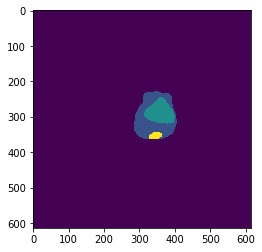

In [148]:
plt.imshow(mask_volume[91])

In [21]:
from prepare_data import extract_info, process_dicom_array, convert_dtypes, process_rtstruct, match_dicoms_and_annotation
from prepare_data import rescale_intensity, apply_ww_wl, normalize_array
from prepare_data import process_dicoms as process_dicoms_old

from skimage.io import imread, imsave


def load_dicom(im):
    try:
        arr = im.pixel_array
    except Exception as e:
        print(f"Exception: {e}\n")
        return None

    if arr.max() == arr.min():
        print("image is blank")
        return None
    
    return arr

def match_dicoms_and_annotation(dicom_metadata, annotations):
    series_info = {}
    for _, annotation in annotations.items():
        annot_uids = [item["uid"] for item in annotation]
        for series_id, metadata_list in dicom_metadata.items():
            dicom_uids = [meta["uid"] for meta in metadata_list]
            matching_uids = [meta["uid"] for meta in metadata_list if meta["uid"] in annot_uids]
            if len(matching_uids) > 1:
                series_info[series_id] = (metadata_list, annotation)

    return series_info


def process_dicoms(input_directory, output_directory=None, orientation="Transverse", 
                   modality="CT", desired_spacing=[0.976562, 0.976562], desired_slice_thickness=2.5):
    """
    args:
      input_directory: path to study date directory
    """
    
    root_dir  = Path(input_directory)
    output_dir  = Path(output_directory)
    dicom_metadata = {}
    dicom_imagedata = {}
    annotations = {}
    for i, pp in enumerate(root_dir.glob('*/*.dcm')):
    # for i, pp in enumerate(root_dir.glob('**/*.dcm')):
        if not pp.is_file():
            continue        
        im = pydicom.dcmread(str(pp))
        metadata, status = extract_info(im)
        if metadata['Modality'] == 'RTSTRUCT':
            annotations[pp] = process_rtstruct(im)
            continue

        if status and metadata["Modality"] == modality and metadata["orientation"] == orientation:
            metadata = convert_dtypes(metadata)
            series_id = metadata["SeriesInstanceUID"]
#             return im, metadata        
#             arr = process_dicom_array(im, metadata)
            arr = load_dicom(im)
            if arr is None:
#                 print("array is none, skipping")
                continue            
            
            metadata['npixels'] = arr.shape

#             pp_rel = pp.relative_to(root_dir)
#             output_pp = (output_dir / pp_rel).with_suffix('.jpg')
#             output_pp.parent.mkdir(exist_ok=True, parents=True)
#             metadata['original_path'] = str(pp)
#             metadata['rel_path'] = str(pp_rel)

#             if output_directory is not None:
# #                 imsave(str(output_pp), (arr * 255).astype(np.uint8))
#                 metadata['output_path'] = str(output_pp)
#                 metadata['output_path_rel'] = str(pp_rel.with_suffix('.jpg'))
            
            
            series_results = dicom_metadata.get(series_id, [])
            series_results.append(metadata)
            dicom_metadata[series_id] = series_results
            
            series_images = dicom_imagedata.get(series_id, [])
            series_images.append(arr)
            dicom_imagedata[series_id] = series_images
#             print("reached end of process_dicoms inside loop")
    
    series_info = match_dicoms_and_annotation(dicom_metadata, annotations)
    
    # take first one assuming in most cases there is only one match per study. Maybe extend to all matches?
    
    if len(series_info) == 0:
        print("No matches between dicoms and annotations")
        return None
    series_id = list(series_info.keys())[0]
    print(series_id)
    serie_info = series_info[series_id]
    metadata_list, annotations = serie_info
    metadata = metadata_list[0]
    sorted_indici = sorted(zip(range(len(metadata_list)), metadata_list), key=lambda x: x[1]['SliceLocation'])
    sorted_indici = [idx for idx, metadata in sorted_indici]
    sorted_images = [dicom_imagedata[series_id][i] for i in sorted_indici]
    volume = np.stack(sorted_images)
    volume = process_volume(
        volume, metadata, desired_slice_thickness=desired_slice_thickness, desired_spacing=desired_spacing)
    
    sorted_metadata_list = [metadata_list[i] for i in sorted_indici]
    mask_volume, encountered_classes = process_annotations(
        annotations, sorted_metadata_list, target_shape=volume.shape, 
        desired_slice_thickness=desired_slice_thickness, desired_spacing=desired_spacing)
    
    
    output_dir.mkdir(exist_ok=True, parents=True)
    
    
    np.savez_compressed(str(output_dir / f'{series_id}.npz'), volume=volume, mask_volume=mask_volume)
    
#     return volume, mask_volume, annotations
    output_keys = [
        'SeriesInstanceUID', 'orientation', 'origin', 'PixelSpacing', 'SliceThickness', 'Modality', 
        'RescaleIntercept', 'RescaleSlope', 'PatientPosition', 'WindowWidth', 'WindowCenter', 'npixels'
    ]
    metadata_filtered = {k:v for k,v in metadata.items() if k in output_keys}
    meta_result = {
        **metadata_filtered, 'labels': encountered_classes, 'input_directory': input_directory, 
        'output_directory': output_directory, 'desired_pixel_spacing': desired_spacing, 
        'desired_slice_thickness': desired_slice_thickness}
    with open(str(output_dir / f'{series_id}.json'), 'w') as meta_output:
        meta_output.write(json.dumps(meta_result))
    
    return meta_result
    
    
    
#     return series_info, dicom_imagedata
#     for series_id, (metadata_list, annotation) in series_info.items():
#         # last match overwrites all preceding matches. assuming that most of the studies have only one match
#         with open(str(output_dir / 'meta.json'), "w") as output_file:
#             json.dump(metadata_list, output_file)

#         with open(str(output_dir / 'annotations.json'), "w") as output_file:
#             json.dump(annotation, output_file)  

#         if label_output_dir is not None:
#             label_pp = (label_output_dir / pp_rel.parent)
#             label_pp.mkdir(exist_ok=True, parents=True)
#             visualize_label(metadata_list, annotation, label_pp)
            
#     return None

from scipy.ndimage import zoom, interpolation


def process_volume(volume, metadata, desired_spacing=[0.976562, 0.976562], desired_slice_thickness=2.5):

    intercept = float(metadata["RescaleIntercept"])
    slope = float(metadata["RescaleSlope"])
    if isinstance(metadata["WindowWidth"], list):
        ww = float(metadata["WindowWidth"][0])
        wl = float(metadata["WindowCenter"][0])
    else:
        ww = float(metadata["WindowWidth"])
        wl = float(metadata["WindowCenter"])
    # ww = float(metadata["WindowWidth"])
    # wl = float(metadata["WindowCenter"])
    arr = rescale_intensity(volume, intercept, slope)
    arr = apply_ww_wl(arr, ww, wl)
    arr = normalize_array(arr)
    if metadata['PatientPosition'] != "HFS":
        arr = arr[:, ::-1, ::-1]
        
    spacing_inplane = [float(metadata['PixelSpacing'][0]), float(metadata['PixelSpacing'][1])]
    slice_thickness = float(metadata['SliceThickness'])
    zoom_factor_inplane = [spacing_inplane[0] / desired_spacing[0], spacing_inplane[1] / desired_spacing[1]]
    zoom_factor_slice = slice_thickness / desired_slice_thickness
    zoom_factor = [zoom_factor_slice] + zoom_factor_inplane
    resampled = zoom(arr, zoom_factor, order=1)


    return resampled

In [77]:
a = {1:2, 3:4}
b = [1,2,3,4]
sorted(b, key=lambda x: a.get(x, -1))

[2, 4, 1, 3]

In [22]:
import skimage

def process_annotations(annotations, sorted_metadata_list, target_shape, desired_spacing=[0.976562, 0.976562], 
                        desired_slice_thickness=2.5, classes=['background', 'bowel_bag', 'bladder', 'hip', 'rectum']):        
    uid_to_slice_idx = dict([(meta['uid'], i) for i, meta in enumerate(sorted_metadata_list)])
#     for annot in annotations:        
#         annot['slice_idx'] = uid_to_slice_idx[annot['uid']]
        
    meta = sorted_metadata_list[0]
    patientposition = meta['PatientPosition']
    origin = meta['origin'][:2]
    pixelspacing = np.array(meta['PixelSpacing'][:2])
    slice_thickness = meta['SliceThickness']
    new_annotations = []
    
    mask_volume = np.zeros((len(sorted_metadata_list), target_shape[1], target_shape[2]))        
    class2idx = dict(zip(classes, range(len(classes))))
        
    slice_label_counts = {}
    for item in sorted(annotations, key=lambda x: uid_to_slice_idx.get(x['uid'], -1)):        
        uid = item["uid"]
        slice_idx = uid_to_slice_idx.get(uid, None)
        if slice_idx is None:
            continue
        coords = item["coords"]
            
        if patientposition=="HFP":
            orientation = np.array([-1, -1])
            coords_pix = orientation*np.array(coords) - orientation*origin  
            coords_pix = coords_pix / pixelspacing
            coords_pix = meta['npixels'] - coords_pix
            zoom_factor = pixelspacing / desired_spacing
            coords_pix = coords_pix * zoom_factor
        else:
            coords_pix = np.array(coords) - origin
            coords_pix = coords_pix / pixelspacing
            zoom_factor = pixelspacing / desired_spacing
            coords_pix = coords_pix * zoom_factor


        label = item["label_name"]
        label_mapped = label_mapping.map_label(label)
        if label_mapped is None:
            continue
        label_idx = class2idx.get(label_mapped)
        if label_idx is None:
            continue
        
            
        if label_mapped != 'hip' and slice_label_counts.get(slice_idx, {}).get(label_mapped, 0) > 0:            
            print(f"Already encountered label {label_mapped} for slice {slice_idx}. Skipping")
            print(f"original label: {label}")
            continue
        elif label_mapped == 'hip' and slice_label_counts.get(slice_idx, {}).get(label_mapped, 0) > 1:
            print(f"Already encountered label {label_mapped} twice for slice {slice_idx}. Skipping")
            continue
        
            
        coords_np = coords_pix
        rr, cc = skimage.draw.polygon(coords_np[:,0], coords_np[:,1], shape=(target_shape[1], target_shape[2]))
        mask_volume[slice_idx, cc, rr] = label_idx
        label_counts = slice_label_counts.get(slice_idx, {label_mapped: 0})
        label_counts[label_mapped] = label_counts.get(label_mapped, 0) + 1
        slice_label_counts[slice_idx] = label_counts
    zoom_factor_slice = slice_thickness / desired_slice_thickness
    # only resample slice dimension because we already handle the other resampling ourselves by
    # transforming the coordinates
    resampled = zoom(mask_volume, [zoom_factor_slice, 1, 1], order=0)
    
    encountered_classes = list(set([cat for count_dict in slice_label_counts.values() for cat in count_dict.keys()]))
    
    return resampled, encountered_classes
    
    
#     spacing_inplane = [float(metadata['PixelSpacing'][0]), float(metadata['PixelSpacing'][1])]
#     slice_thickness = float(metadata['SliceThickness'])
#     zoom_factor_inplane = [spacing_inplane[0] / desired_spacing[0], spacing_inplane[1] / desired_spacing[1]]
#     zoom_factor_slice = slice_thickness / desired_slice_thickness
#     zoom_factor = [zoom_factor_slice] + zoom_factor_inplane
#     resampled = zoom(arr, zoom_factor, order=1)

IMPORTANT:
* 3354140472_2065120512/20140716/
  * Origin incorrect? Or calculation incorrect
* A lot of cases have multiple annotations
  * check if this is a problem because we pick only one
* Include ordering of overlapping organs!

In [23]:
output_path

'/export/scratch3/bvdp/segmentation/data/MODIR_data_preprocessed_train_09-04-2020/'

In [19]:
root_dir = Path(root_path)
output_dir = Path(output_path)
label_output_dir = Path(label_output_path)

dcm_paths = root_dir.glob('**/*dcm')
dcm_base_folders = list(set([dcm_p.parent.parent for dcm_p in dcm_paths]))
# meta_results = []
print("Number of folders: ", len(dcm_base_folders))

Number of folders:  1009


In [52]:
test_cases = ["3447649083_2300408382","1251607822_3360809567","1776221421_3623711384","4138765430_4288375808","4138765430_4288375808","71002659_1393596829","3250869600_1472266577","3105240199_2802898234","3105240199_2802898234","3071715186_2697720285","1575074331_3828260369","2877614082_2807570210","2470572094_7087840","35275123_1080536430","992212958_3937481107","1110666631_3291094668","743182001_2914122834","988013551_2288154224","2659660131_4152562968","3324181515_3012541438","2786172418_554570168","1753681845_3020742114","1753681845_3020742114","197732510_1374905733","1657804237_1186814789","1496914410_3506128588","148247941_1477408201","2727871041_2135952967","866529188_2380907469","256368460_2496857562","2862551300_3512082767","2862551300_3512082767","2862551300_3512082767","2862551300_3512082767","1470856264_3793933726","1988912392_3742505486","3492530768_270825224","3537130633_3529168242","3537130633_3529168242","3921185102_2989529501","250585633_3368605020","840923293_1081097806","840923293_1081097806","156733794_1328676966","3233114526_1289816699","2842173381_548505425","2475363084_1388429027","1848239153_4206789217","99175551_3298458114","1349313258_4113403188","3228946055_450089926","1583535891_2324733240","4243431584_4106314539","2314573991_1935594109","3561376302_3572857692","2035127189_1641783513","1047032288_274330426","2705346922_2022041085","143617278_3168196814","1264716875_2710935007","4241913603_2018878661","2592098249_2469318056","2546511718_112609233","2980170391_581583557","3091784604_2117440478","2452392323_4135781147","349456454_2451289617","3726302091_425794354","390786259_3553980411","2366557175_2413623965","2366557175_2413623965","2366557175_2413623965","4243876948_35394361","3271242082_1518408218","3271242082_1518408218","865803397_3949601865","319349729_1780640195","2710297743_285119374","4084983997_3356463198","4040773554_3381615017","2371410408_2785947661","2560694506_2986903100","1649676299_4104245639","3725802166_2652341432","598938936_1249521328","4081995687_1665625372","3881179734_3806374314","3754150382_1194737573","2832977878_1999175996","777907242_386711448","2477741492_1072758908","3845935113_3845540828"]

In [55]:
str(pp.relative_to(root_path))

'197988794_3029052767'

In [72]:
[i for i, path in enumerate(dcm_base_folders) if '3320725439_351012659/20170125' in str(path)]

[745]

In [73]:
recompute = False

for i, pp in enumerate(dcm_base_folders[745:]):
    dicom_path = str(output_path / pp.relative_to(root_path))    
    dicom_label_path = str(label_output_path / pp.relative_to(root_path))
    if not recompute and len(list(Path(dicom_path).glob('*.json'))) > 0:
        print(f"Already processed. Skipping {dicom_path}..")
        continue
    results = process_dicoms(str(pp), output_directory=dicom_path)
    print(f'{i} out of {len(dcm_base_folders)}')

Exception: The length of the pixel data in the dataset doesn't match the expected amount (216140 vs. 524288 bytes). The dataset may be corrupted or there may be an issue with the pixel data handler.

1.2.826.0.1.3680043.2.135.737157.54716028.7.1558559284.0.79


/export/scratch3/bvdp/segmentation/env/lib64/python3.6/site-packages/scipy/ndimage/interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


KeyError: '1.2.826.0.1.3680043.2.135.737157.54716028.7.1558559322.421.64'

In [58]:
dicom_path

'/export/scratch3/bvdp/segmentation/data/MODIR_data_preprocessed_train_09-04-2020/2842173381_548505425'

In [119]:
import pandas as pd

In [182]:
paths = list(output_dir.glob('**/*.json'))

print("total data: {}".format(len(paths)))
# paths = [path.parent for path in paths]
# root_paths = [root_dir1]*len(paths1) + [root_dir2]*len(paths2) + [root_dir3]*len(paths3)
# ## Load annotations

meta_list = []
for path in paths:
    with open(str(path)) as f:
        meta = json.loads(f.read())
        meta_list.append(meta)
    


df = pd.DataFrame(meta_list)

total data: 771


In [183]:
df[df.labels.map(l)]

,Modality,PatientPosition,PixelSpacing,RescaleIntercept,RescaleSlope,SeriesInstanceUID,SliceThickness,WindowCenter,WindowWidth,desired_pixel_spacing,desired_slice_thickness,input_directory,labels,npixels,orientation,origin,output_directory
0,CT,HFP,"[1.269531, 1.269531]",-1024.0,1.0,1.2.826.0.1.3680043.2.135.737157.54716028.7.15...,2.50,40,400,"[0.976562, 0.976562]",2.5,/export/scratch2/grewal/Data/Projects_DICOM_da...,"[hip, bladder, bowel_bag]","[512, 512]",Transverse,"[325.0, 325.0, 37.5]",/export/scratch3/bvdp/segmentation/data/MODIR_...
1,CT,HFS,"[0.976562, 0.976562]",-1024.0,1.0,1.2.826.0.1.3680043.2.135.737157.54716028.7.15...,2.50,40,400,"[0.976562, 0.976562]",2.5,/export/scratch2/grewal/Data/Projects_DICOM_da...,"[bladder, hip, bowel_bag]","[512, 512]",Transverse,"[-250.0, -250.0, 205.0]",/export/scratch3/bvdp/segmentation/data/MODIR_...
2,CT,HFS,"[1.171875, 1.171875]",-1024.0,1.0,1.2.826.0.1.3680043.2.135.737157.54716028.7.15...,2.50,40,400,"[0.976562, 0.976562]",2.5,/export/scratch2/grewal/Data/Projects_DICOM_da...,"[bladder, rectum]","[512, 512]",Transverse,"[-300.0, -300.0, -80.25]",/export/scratch3/bvdp/segmentation/data/MODIR_...
3,CT,HFS,"[1.171875, 1.171875]",-1024.0,1.0,1.2.826.0.1.3680043.2.135.737157.54716028.7.15...,2.50,40,400,"[0.976562, 0.976562]",2.5,/export/scratch2/grewal/Data/Projects_DICOM_da...,"[bladder, rectum]","[512, 512]",Transverse,"[-300.0, -300.0, -97.0]",/export/scratch3/bvdp/segmentation/data/MODIR_...
4,CT,HFS,"[1.171875, 1.171875]",-1024.0,1.0,1.2.826.0.1.3680043.2.135.737157.54716028.7.15...,1.25,40,400,"[0.976562, 0.976562]",2.5,/export/scratch2/grewal/Data/Projects_DICOM_da...,"[bladder, rectum]","[512, 512]",Transverse,"[-300.0, -300.0, -60.0]",/export/scratch3/bvdp/segmentation/data/MODIR_...
5,CT,HFS,"[1.171875, 1.171875]",-1024.0,1.0,1.2.826.0.1.3680043.2.135.737157.54716028.7.15...,2.50,40,400,"[0.976562, 0.976562]",2.5,/export/scratch2/grewal/Data/Projects_DICOM_da...,"[bladder, rectum]","[512, 512]",Transverse,"[-300.0, -300.0, -64.5]",/export/scratch3/bvdp/segmentation/data/MODIR_...
6,CT,HFS,"[0.976562, 0.976562]",-1024.0,1.0,1.2.826.0.1.3680043.2.135.737157.54716028.7.15...,2.50,40,400,"[0.976562, 0.976562]",2.5,/export/scratch2/grewal/Data/Projects_DICOM_da...,"[bladder, hip, bowel_bag]","[512, 512]",Transverse,"[-250.0, -250.0, 82.5]",/export/scratch3/bvdp/segmentation/data/MODIR_...
7,CT,HFS,"[1.269531, 1.269531]",-1024.0,1.0,1.2.826.0.1.3680043.2.135.737157.54716028.7.15...,2.50,40,400,"[0.976562, 0.976562]",2.5,/export/scratch2/grewal/Data/Projects_DICOM_da...,"[bladder, rectum]","[512, 512]",Transverse,"[-325.0, -325.0, -3.75]",/export/scratch3/bvdp/segmentation/data/MODIR_...
8,CT,HFP,"[1.269531, 1.269531]",-1024.0,1.0,1.2.826.0.1.3680043.2.135.737157.54716028.7.15...,2.50,40,400,"[0.976562, 0.976562]",2.5,/export/scratch2/grewal/Data/Projects_DICOM_da...,"[bladder, hip, bowel_bag]","[512, 512]",Transverse,"[325.0, 325.0, 167.5]",/export/scratch3/bvdp/segmentation/data/MODIR_...
9,CT,HFP,"[1.171875, 1.171875]",-1024.0,1.0,1.2.826.0.1.3680043.2.135.737157.54716028.7.15...,3.00,"[50.0, 50.0]","[400.0, 400.0]","[0.976562, 0.976562]",2.5,/export/scratch2/grewal/Data/Projects_DICOM_da...,"[bladder, rectum]","[512, 512]",Transverse,"[-300.0, 245.0, -381.5]",/export/scratch3/bvdp/segmentation/data/MODIR_...


In [137]:
test_file = df.apply(lambda x: f'{x.output_directory}/{x.SeriesInstanceUID}.npz', axis=1).iloc[0]
with np.load(test_file) as datapoint:
    volume, mask_volume = datapoint['volume'], datapoint['mask_volume']

In [138]:
volume.shape, mask_volume.shape

((147, 666, 666), (147, 666, 666))

In [59]:
test_file = '/export/scratch3/bvdp/segmentation/data/MODIR_data_preprocessed_train_09-04-2020/2842173381_548505425/1.2.826.0.1.3680043.2.135.737157.54716028.7.1569956492.562.55.npz'
x = np.load(test_file)
volume, mask_volume = x['volume'], x['mask_volume']

In [11]:
import torch_AMCDataset

from importlib import reload  

reload(torch_AMCDataset)

<module 'torch_AMCDataset' from '/export/scratch3/bvdp/segmentation/OAR_segmentation/experiments/unet/notebooks/torch_AMCDataset.py'>

In [12]:
root_dir = '/export/scratch3/bvdp/segmentation/data/MODIR_data_preprocessed_train_23-04-2020/'
# meta_path = "/export/scratch3/bvdp/segmentation/OAR_segmentation/experiments/unet/notebooks/dataset_train_09-04-2020.csv"
meta_path = "/export/scratch3/bvdp/segmentation/OAR_segmentation/data_preparation/meta/dataset_train_2020-04-23.csv"
dataset = torch_AMCDataset.AMCDataset(root_dir, meta_path, output_size=512, is_training=True)
dataset_val = torch_AMCDataset.AMCDataset(root_dir, meta_path, output_size=512, is_training=False)

In [13]:
dataset.meta_df.iloc[0].path

'/export/scratch3/bvdp/segmentation/data/MODIR_data_preprocessed_train_23-04-2020/3447649083_2300408382'

Probleemgeval:
* '/export/scratch3/bvdp/segmentation/data/MODIR_data_preprocessed_train_09-04-2020/3450012419_1594035157'
  * Maar 1 heup
* 4081995687_1665625372
  * inconsistente bowel bag labels. Flicker aan/uit per frame, maar ook soms annotatie van deeltje van bowel
* 349456454_2451289617
  * missende heup, layering bowel bag / bladder, flickering
* 3233114526_1289816699
  * bladder turns into bowel bag

In [340]:
# dataset.meta_df

In [14]:
tmp = dataset.meta_df.reset_index()
tmp[tmp.path.str.contains('323311')]

,index,Modality,PatientPosition,PixelSpacing,RescaleIntercept,RescaleSlope,SeriesInstanceUID,SliceThickness,WindowCenter,WindowWidth,...,orientation,origin,path,root_path,patient_id,hip,bowel_bag,bladder,rectum,train
54,392,CT,HFS,"[1.171875, 1.171875]",-1024.0,1.0,1.2.826.0.1.3680043.2.135.737157.54716028.7.15...,3.0,"[50.0, 50.0]","[400.0, 400.0]",...,Transverse,"[-300.0, -230.0, -187.0]",/export/scratch3/bvdp/segmentation/data/MODIR_...,/export/scratch3/bvdp/segmentation/data/MODIR_...,3233114526_1289816699,1,1,1,1,True


In [15]:
volume, mask_volume = dataset[54]

In [16]:
volume.shape, mask_volume.shape

((1, 206, 614, 614), (206, 614, 614))

In [118]:
mask_volume.shape

(206, 614, 614)

In [316]:
import matplotlib.pyplot as plt

In [360]:
# mask_volume

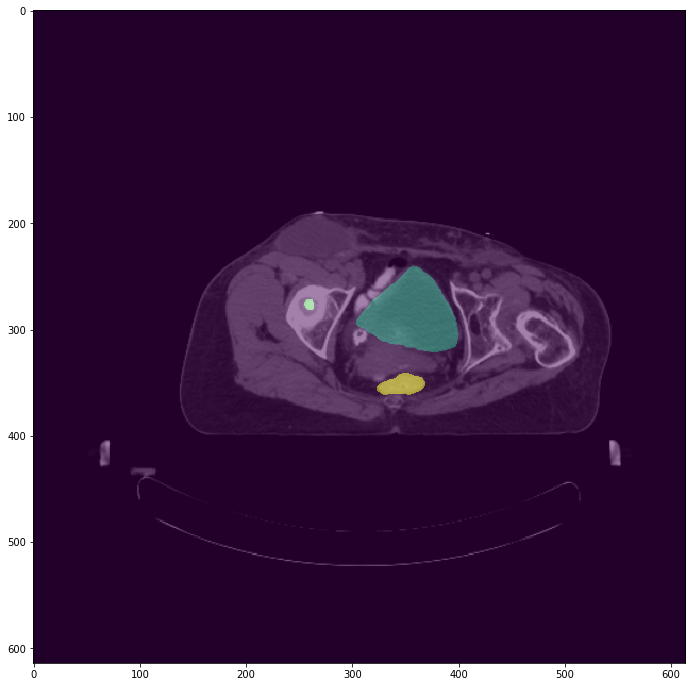

In [21]:
fig, ax = plt.subplots(figsize=(12,12))
slice_i = 90
ax.imshow(volume[0,slice_i], cmap='gray')
ax.imshow(mask_volume[slice_i], alpha=0.5)

In [276]:
# test_vol = volume[0,slice_i].copy()
test_mask = mask_volume.copy()

In [277]:
classes = ['background', 'bowel_bag', 'bladder', 'hip', 'rectum']
class2idx = dict(zip(classes, range(len(classes))))

class_layering = ['background', 'bowel_bag', 'bladder', 'hip', 'rectum']
class2layeridx = dict(zip(class_layering, range(len(classes))))
class_layer_indici = np.array([class2layeridx[cls] for cls in classes])

new_cls = 'bowel_bag'
new_cls_idx = class2idx[new_cls]

In [278]:
coords_np = np.array([[165,165,260,260],[200,310,310,200]]).transpose()
target_shape = test_vol.shape
rr, cc = skimage.draw.polygon(coords_np[:,0], coords_np[:,1], shape=(target_shape[0], target_shape[1]))

overwrite_mask = class_layer_indici[test_mask[slice_i, cc,rr]] < class_layer_indici[new_cls_idx]
rr, cc = rr[overwrite_mask], cc[overwrite_mask]
test_mask[slice_i, cc,rr] = new_cls_idx

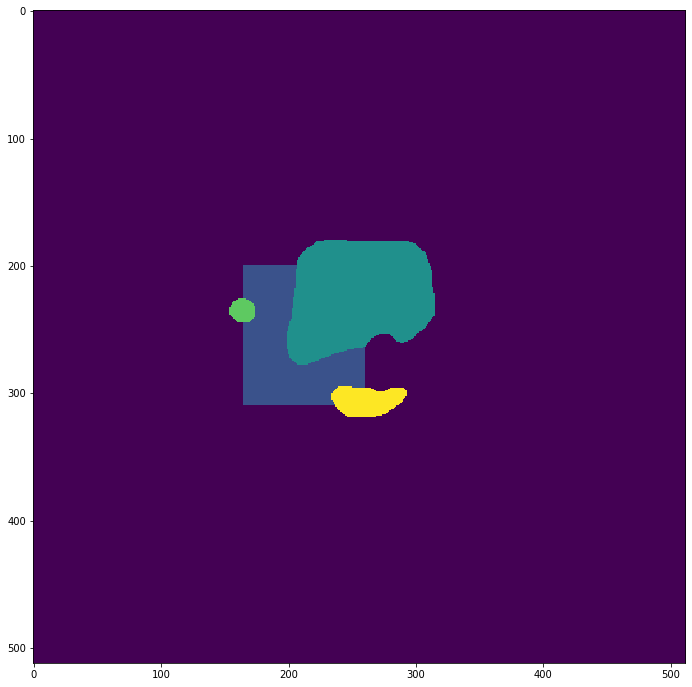

In [268]:
fig, ax = plt.subplots(figsize=(12,12))
ax.imshow(test_vol, cmap='gray')
ax.imshow(test_mask, alpha=1)

In [282]:
test_path = '/export/scratch3/bvdp/segmentation/data/MODIR_data_preprocessed_train_23-04-2020/3544822755_636590662/1.2.826.0.1.3680043.2.135.737157.54716028.7.1569315808.375.54.npz'
np_file = np.load(test_path)

In [284]:
test_vol, mask_vol = np_file['volume'], np_file['mask_volume']

In [288]:
test_vol.shape

(173, 614, 614)

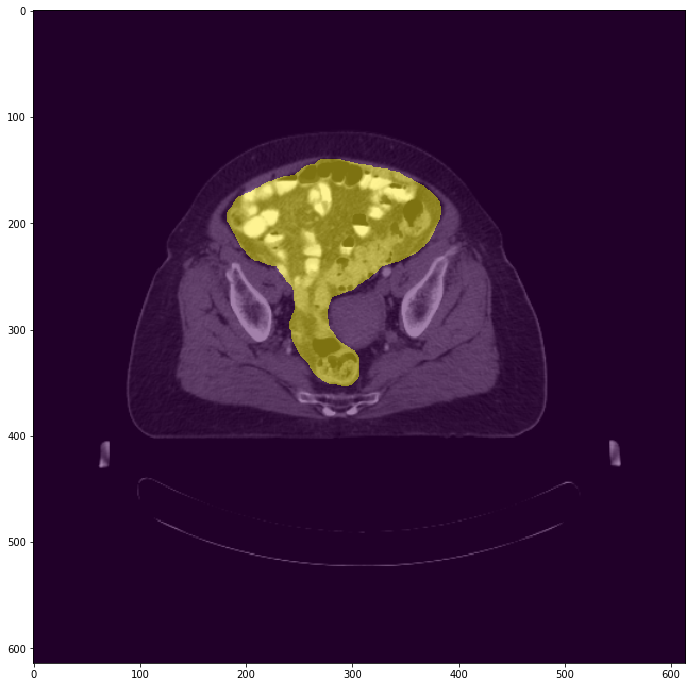

In [310]:
slice_i = 70
fig, ax = plt.subplots(figsize=(12,12))
ax.imshow(test_vol[slice_i], cmap='gray')
ax.imshow(mask_vol[slice_i], alpha=0.5)

In [131]:
from skimage.io import imread, imsave

def visualize_data(volume, mask_volume, output_dir):
    colors = {0: (1, 0, 0), 1: (1, 0, 1), 2: (0, 1, 0), 3: (0, 0, 1),
                4: (1, 1, 0), 5: (0, 1, 1), 6: (1, 0, 1),
                7: (1, 0.5, 0), 8: (0, 1, 0.5), 9: (0.5, 0, 1),
                10: (0.5, 1, 0), 11: (0, 0.5, 1), 12: (1, 0, 0.5)}
    
    volume = volume[0]
    n_slices = volume.shape[0]
    for i in range(n_slices):
        img = volume[i]
        mask = mask_volume[i]
        combined = np.stack((img,)*3, axis=-1)
        opacity = 0.5
        for j in [1,2,3,4]:
            combined[mask == j] = opacity*np.array(colors[j]) + np.stack(((1-opacity)*img[mask == j],)*3, axis=-1)
        combined = np.concatenate((combined, np.stack((img,)*3, axis=-1)), axis=1)
        
        output_path = Path(output_dir) / f"{i}.jpg"
        output_path.parent.mkdir(exist_ok=True, parents=True)
        imsave(str(output_path), (combined * 255).astype(np.uint8))

In [56]:
volume, mask_volume = dataset[20]

In [57]:
volume.shape, mask_volume.shape

((1, 173, 614, 614), (173, 614, 614))

In [108]:
Path('./test_folder/1.jpg').parent

PosixPath('test_folder')

In [151]:
studies = dataset.meta_df.apply(lambda x: Path(x.path).relative_to(Path(x.root_path)), axis=1)
for i, study in zip(range(len(studies)), studies.values):
    print(i, end=',')
    volume, mask_volume = dataset[i]
    visualize_data(volume, mask_volume, f'./test_visualize/{study}')

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,

KeyboardInterrupt: 

In [132]:
result = visualize_data(volume, mask_volume, './test_visualize/')

In [126]:
imsave('./test_visualize/1.jpg', (result * 255).astype(np.uint8))

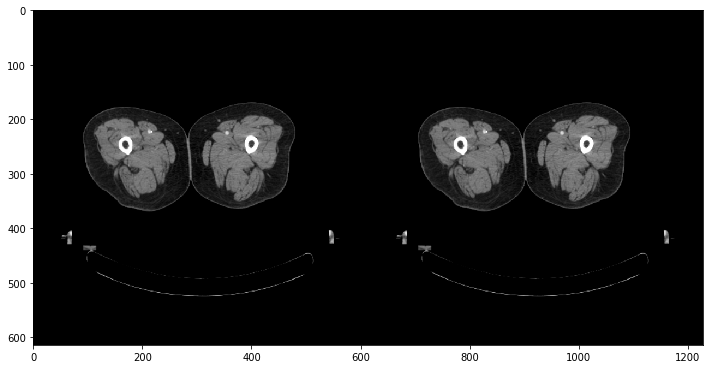

In [124]:
fig, ax = plt.subplots(figsize=(12,12))
ax.imshow(result)

In [36]:
np.unique(mask_volume.ravel())

array([0, 1, 2, 3, 4])

In [49]:
volume[0,50][(mask_volume[50] == 2)] = 

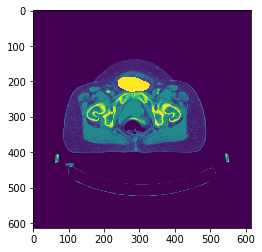

In [50]:
plt.imshow(volume[0,50])

In [35]:
volume.max()

1.0

In [31]:
len(volume[0])

173

In [312]:
pd.Series(mask_volume.ravel()).value_counts()

0.0    33840171
2.0       48773
4.0       40696
dtype: int64

In [314]:
pd.Series(mask_volume[24].ravel()).value_counts()

0.0    371256
2.0      4474
4.0      1266
dtype: int64

In [124]:
series_id = list(series_info.keys())[0]
print(series_id)
bla = series_info[series_id]
metadata_list, annotation = bla
metadata = metadata_list[0]
sorted_indici = sorted(zip(range(len(metadata_list)), metadata_list), key=lambda x: x[1]['SliceLocation'])
sorted_indici = [idx for idx, metadata in sorted_indici]
sorted_images = [dicom_imagedata[series_id][i] for i in sorted_indici]
volume = np.stack(sorted_images)
volume = process_volume(volume, metadata, desired_slice_thickness=3, desired_spacing=[0.8, 0.8])
volume.shape

1.2.826.0.1.3680043.2.135.737157.54716028.7.1568986830.328.33


/export/scratch3/bvdp/segmentation/env/lib64/python3.6/site-packages/scipy/ndimage/interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


(104, 625, 625)

In [286]:
test = process_annotations(annotation, sorted_metadata_list, target_shape=volume.shape, desired_slice_thickness=3.0, desired_spacing=[0.8,0.8])
test.shape

(104, 625, 625)

In [287]:
volume.shape

(104, 625, 625)

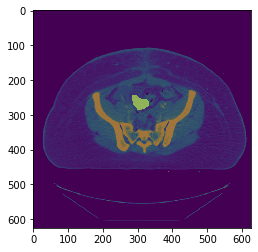

In [295]:
fig, ax = plt.subplots()
ax.imshow(volume[70])
plt.imshow(test[70], alpha=0.5)

In [62]:
sorted_metadata_list = [metadata_list[i] for i in sorted_indici]
uid_to_slice_idx = dict([(meta['uid'], i) for i, meta in enumerate(sorted_metadata_list)])
for annot in annotation:
    annot['slice_idx'] = uid_to_slice_idx[annot['uid']]

In [63]:
def process_annotation_new(item, meta, desired_spacing=[0.976562, 0.976562], desired_slice_thickness=2.5):
    meta = meta[0]
    patientposition = meta['PatientPosition']
    origin = meta['origin'][:2]
    pixelspacing = np.array(meta['PixelSpacing'][:2])

    coords = item["coords"]
    if patientposition=="HFP":
        orientation = np.array([-1, -1])
        coords_pix = orientation*np.array(coords) - orientation*origin  
        coords_pix = coords_pix / pixelspacing
        coords_pix = meta['npixels'] - coords_pix
        zoom_factor = pixelspacing / desired_spacing
        coords_pix = coords_pix * zoom_factor
    else:
        coords_pix = np.array(coords) - origin
        coords_pix = coords_pix / pixelspacing
        zoom_factor = pixelspacing / desired_spacing
        coords_pix = coords_pix * zoom_factor
    new_item = item.copy()
    new_item["coords"] = coords_pix.tolist()
    new_item["slice_idx"] = int(item['slice_idx'] * meta['SliceThickness'] / desired_slice_thickness)

    return new_item

In [57]:
metadata

{'SeriesInstanceUID': '1.2.826.0.1.3680043.2.135.737157.54716028.7.1568986830.328.33',
 'uid': '1.2.826.0.1.3680043.2.135.737157.54716028.7.1568986865.203.77',
 'orientation': 'Transverse',
 'origin': [-250.0, -250.0, 20.0],
 'SliceLocation': 20.0,
 'PixelSpacing': ["0.976562", "0.976562"],
 'SliceThickness': 2.5,
 'Modality': 'CT',
 'RescaleIntercept': -1024.0,
 'RescaleSlope': 1.0,
 'PatientPosition': 'HFS',
 'WindowWidth': 400.0,
 'WindowCenter': 40.0,
 'npixels': (512, 512),
 'original_path': '/export/scratch2/grewal/Data/Projects_DICOM_data/ThreeD/MODIR_data_train_split/804639524_2962955031/2/1.2.826.0.1.3680043.2.135.737157.54716028.7.1568986865.203.77.dcm',
 'rel_path': '2/1.2.826.0.1.3680043.2.135.737157.54716028.7.1568986865.203.77.dcm',
 'output_path': '/export/scratch3/bvdp/segmentation/data/test_fix_voxel_new/804639524_2962955031/2/1.2.826.0.1.3680043.2.135.737157.54716028.7.1568986865.203.77.jpg',
 'output_path_rel': '2/1.2.826.0.1.3680043.2.135.737157.54716028.7.156898686

In [82]:
annotations_new = [process_annotation_new(annot, metadata_list, desired_spacing=[0.8,0.8], desired_slice_thickness=3) for annot in annotation if annot['label_name'] == 'blaas']

In [111]:
annot = annotations_new[0]
all_coords = np.vstack([np.hstack((annot['coords'], np.ones((len(annot['coords']), 1))*annot['slice_idx'])) for annot in annotations_new])
all_coords

array([[308.2275    , 255.7375    ,  70.        ],
       [316.7725    , 255.7375    ,  70.        ],
       [327.75875   , 261.84125   ,  70.        ],
       ...,
       [302.12375   , 280.15125   ,  35.        ],
       [309.4475    , 272.82749875,  35.        ],
       [314.33125   , 271.60625   ,  35.        ]])

In [121]:
# np.meshgrid(all_coords[:,0], all_coords[:,1], all_coords[:,2])

In [102]:
annotation[24]

{'uid': '1.2.826.0.1.3680043.2.135.737157.54716028.7.1568986899.531.20',
 'label_name': 'blaas',
 'coords': [[-20.02, -74.707001],
  [-9.277, -74.707001],
  [-7.324, -73.731003],
  [6.348, -70.801003],
  [17.09, -66.894997],
  [27.832001, -61.035],
  [35.644001, -55.175999],
  [42.48, -47.362999],
  [46.387001, -38.574001],
  [50.292999, -27.832001],
  [51.269001, -18.066999],
  [41.504002, 1.465],
  [28.808001, 9.277],
  [18.066, 14.16],
  [5.371, 11.23],
  [-19.042999, 11.23],
  [-20.996, 12.207],
  [-24.902, 12.207],
  [-32.715, 4.394],
  [-33.692001, 2.441],
  [-37.598, -2.442],
  [-40.527, -11.231],
  [-41.504002, -19.042999],
  [-40.527, -24.902],
  [-40.527, -41.504002],
  [-41.504002, -43.457001],
  [-42.480999, -56.152],
  [-39.550999, -62.012001],
  [-35.645, -66.894997],
  [-31.738001, -68.848],
  [-28.809, -71.777],
  [-22.948999, -73.731003],
  [-20.996, -73.731003]],
 'slice_idx': 61}

In [76]:
process_annotation_new(annotation[24], metadata_list, desired_spacing=[0.8,0.8], desired_slice_thickness=3)

{'uid': '1.2.826.0.1.3680043.2.135.737157.54716028.7.1568986899.531.20',
 'label_name': 'blaas',
 'coords': [[287.47499999999997, 219.11624875],
  [300.90375, 219.11624875],
  [303.34499999999997, 220.33624625],
  [320.435, 223.99874625],
  [333.86249999999995, 228.88125375],
  [347.29000125, 236.20625],
  [357.05500125, 243.53000125],
  [365.59999999999997, 253.29625124999998],
  [370.48375125, 264.28249875],
  [375.36624875, 277.70999875],
  [376.58625125, 289.91625125],
  [364.38000250000005, 314.33125],
  [348.51000125, 324.09625],
  [335.0824999999999, 330.20000000000005],
  [319.21375, 326.5375],
  [288.69625125, 326.5375],
  [286.255, 327.75874999999996],
  [281.3725, 327.75874999999996],
  [271.60625, 317.9925],
  [270.38499874999997, 315.55125],
  [265.5025, 309.4475],
  [261.84125, 298.46125],
  [260.61999749999995, 288.69625125],
  [261.84125, 281.3725],
  [261.84125, 260.61999749999995],
  [260.61999749999995, 258.17874875],
  [259.39875125, 242.31],
  [263.06125125, 234.98

In [79]:
annotation

[{'uid': '1.2.826.0.1.3680043.2.135.737157.54716028.7.1568986878.625.94',
  'label_name': 'blaas',
  'coords': [[-3.418, -45.41],
   [3.418, -45.41],
   [12.207, -40.527],
   [12.207, -34.667999],
   [8.301, -27.832001],
   [3.418, -24.902],
   [-5.371, -29.785],
   [-11.231, -35.645],
   [-10.254, -42.480999],
   [-4.395, -44.433998]],
  'slice_idx': 85},
 {'uid': '1.2.826.0.1.3680043.2.135.737157.54716028.7.1568986879.437.95',
  'label_name': 'blaas',
  'coords': [[-22.948999, -55.175999],
   [-12.207, -55.175999],
   [-6.348, -49.316002],
   [0.488, -46.387001],
   [6.348, -45.41],
   [12.207, -45.41],
   [15.137, -41.504002],
   [17.09, -34.667999],
   [14.16, -29.785],
   [5.371, -23.926001],
   [-3.418, -20.996],
   [-10.254, -20.996],
   [-20.996, -34.667999],
   [-22.948999, -47.362999]],
  'slice_idx': 84},
 {'uid': '1.2.826.0.1.3680043.2.135.737157.54716028.7.1568986880.218.96',
  'label_name': 'blaas',
  'coords': [[-20.996, -62.012001],
   [-12.207, -62.012001],
   [-5.371,

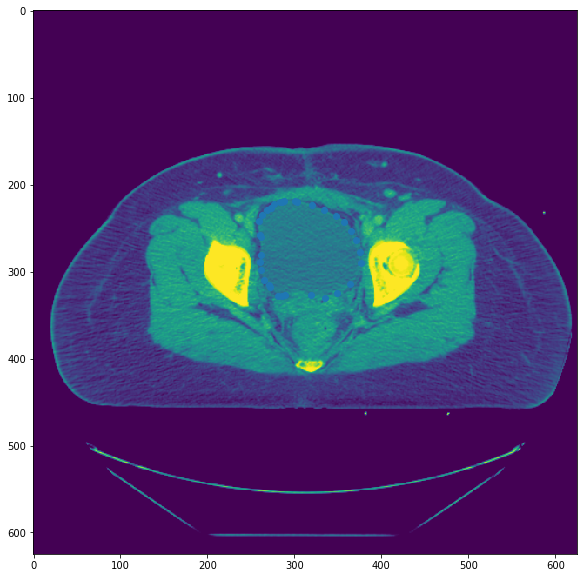

In [68]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(volume[50])
coords = np.array(process_annotation_new(annotation[24], metadata_list, desired_slice_thickness=3, desired_spacing=[0.8,0.8])['coords'])
ax.scatter(coords[:,0], coords[:,1])

In [185]:
# coords

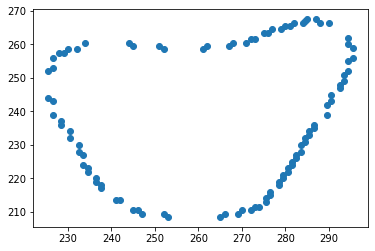

In [194]:
coords = np.array(process_annotation_new(annotation[24], metadata_list)['coords'])
# coords = np.array(annotation[24]['coords'])
# coords = coords - metadata['origin'][:2]
plt.scatter(coords[:,0], coords[:,1])

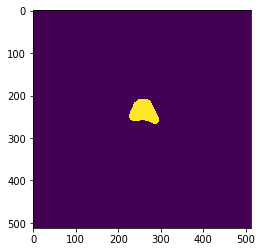

In [192]:
coords_np = coords
rr, cc = skimage.draw.polygon(coords_np[:,0], coords_np[:,1], shape=(512, 512))
test_img = np.zeros((512, 512))
test_img[cc, rr] = 1
plt.imshow(test_img)

In [125]:
sorted_indici[20]

23

In [195]:
metadata

{'SeriesInstanceUID': '1.2.826.0.1.3680043.2.135.737157.54716028.7.1570553499.687.86',
 'uid': '1.2.826.0.1.3680043.2.135.737157.54716028.7.1570553503.703.11',
 'orientation': 'Transverse',
 'origin': [-250.0, -250.0, -52.5],
 'SliceLocation': -52.5,
 'PixelSpacing': ["0.976562", "0.976562"],
 'SliceThickness': 2.5,
 'Modality': 'CT',
 'RescaleIntercept': -1024.0,
 'RescaleSlope': 1.0,
 'PatientPosition': 'HFS',
 'WindowWidth': 400.0,
 'WindowCenter': 40.0,
 'npixels': (512, 512),
 'original_path': '/export/scratch2/grewal/Data/Projects_DICOM_data/ThreeD/MODIR_data_train_split/2341275532_2148974490/2/1.2.826.0.1.3680043.2.135.737157.54716028.7.1570553503.703.11.dcm',
 'rel_path': '2/1.2.826.0.1.3680043.2.135.737157.54716028.7.1570553503.703.11.dcm',
 'output_path': '/export/scratch3/bvdp/segmentation/data/test_fix_voxel_new/2341275532_2148974490/2/1.2.826.0.1.3680043.2.135.737157.54716028.7.1570553503.703.11.jpg',
 'output_path_rel': '2/1.2.826.0.1.3680043.2.135.737157.54716028.7.15705

In [114]:
np.array(annotation[0]['coords']) - np.array([-1, -1])*metadata['origin'][:2] 

array([[-307.617   ,  233.359   ],
       [-307.031   ,  233.945   ],
       [-305.859   ,  232.773   ],
       [-303.516   ,  232.773   ],
       [-298.242   ,  227.5     ],
       [-298.242   ,  223.983999],
       [-301.172   ,  221.055   ],
       [-304.688   ,  221.055   ],
       [-307.031   ,  223.398001],
       [-308.203   ,  222.226999],
       [-310.547   ,  222.226999],
       [-311.719   ,  223.398001],
       [-312.891   ,  223.398001],
       [-314.648   ,  225.156   ],
       [-314.648   ,  229.844   ],
       [-312.891   ,  231.602   ],
       [-311.719   ,  231.602   ],
       [-310.547   ,  232.773   ],
       [-308.203   ,  232.773   ]])

In [105]:
metadata_list[0]

{'SeriesInstanceUID': '1.2.826.0.1.3680043.2.135.737157.54716028.7.1558563238.109.62',
 'uid': '1.2.826.0.1.3680043.2.135.737157.54716028.7.1558563283.203.44',
 'orientation': 'Transverse',
 'origin': [-300.0, 245.0, -283.0],
 'SliceLocation': -283.0,
 'PixelSpacing': ["1.171875", "1.171875"],
 'SliceThickness': 3.0,
 'Modality': 'CT',
 'RescaleIntercept': -1024.0,
 'RescaleSlope': 1.0,
 'PatientPosition': 'HFP',
 'WindowWidth': ["00400", "00400"],
 'WindowCenter': ["00050", "00050"],
 'npixels': (512, 512),
 'original_path': '/export/scratch2/grewal/Data/Projects_DICOM_data/ThreeD/MODIR_data_train_split/3354140472_2065120512/20140716/2/1.2.826.0.1.3680043.2.135.737157.54716028.7.1558563283.203.44.dcm',
 'rel_path': '2/1.2.826.0.1.3680043.2.135.737157.54716028.7.1558563283.203.44.dcm',
 'output_path': '/export/scratch3/bvdp/segmentation/data/test_fix_voxel_new/3354140472_2065120512/20140716/2/1.2.826.0.1.3680043.2.135.737157.54716028.7.1558563283.203.44.jpg',
 'output_path_rel': '2/1.2

In [104]:
annotation[0]

{'uid': '1.2.826.0.1.3680043.2.135.737157.54716028.7.1558563308.46.90',
 'label_name': 'bladder',
 'coords': [[-7.617, -11.641],
  [-7.031, -11.055],
  [-5.859, -12.227],
  [-3.516, -12.227],
  [1.758, -17.5],
  [1.758, -21.016001],
  [-1.172, -23.945],
  [-4.688, -23.945],
  [-7.031, -21.601999],
  [-8.203, -22.773001],
  [-10.547, -22.773001],
  [-11.719, -21.601999],
  [-12.891, -21.601999],
  [-14.648, -19.844],
  [-14.648, -15.156],
  [-12.891, -13.398],
  [-11.719, -13.398],
  [-10.547, -12.227],
  [-8.203, -12.227]],
 'slice_idx': 57}

In [101]:
annotation[0]

{'uid': '1.2.826.0.1.3680043.2.135.737157.54716028.7.1558563308.46.90',
 'label_name': 'bladder',
 'coords': [[-7.617, -11.641],
  [-7.031, -11.055],
  [-5.859, -12.227],
  [-3.516, -12.227],
  [1.758, -17.5],
  [1.758, -21.016001],
  [-1.172, -23.945],
  [-4.688, -23.945],
  [-7.031, -21.601999],
  [-8.203, -22.773001],
  [-10.547, -22.773001],
  [-11.719, -21.601999],
  [-12.891, -21.601999],
  [-14.648, -19.844],
  [-14.648, -15.156],
  [-12.891, -13.398],
  [-11.719, -13.398],
  [-10.547, -12.227],
  [-8.203, -12.227]],
 'slice_idx': 57}

In [47]:
# sorted_metadata_list[0]

In [30]:
print(len(metadata_list))
metadata

144


{'SeriesInstanceUID': '1.2.826.0.1.3680043.2.135.737157.54716028.7.1558563238.109.62',
 'uid': '1.2.826.0.1.3680043.2.135.737157.54716028.7.1558563283.203.44',
 'orientation': 'Transverse',
 'origin': [-300.0, 245.0, -283.0],
 'SliceLocation': -283.0,
 'PixelSpacing': ["1.171875", "1.171875"],
 'SliceThickness': 3.0,
 'Modality': 'CT',
 'RescaleIntercept': -1024.0,
 'RescaleSlope': 1.0,
 'PatientPosition': 'HFP',
 'WindowWidth': ["00400", "00400"],
 'WindowCenter': ["00050", "00050"],
 'original_path': '/export/scratch2/grewal/Data/Projects_DICOM_data/ThreeD/MODIR_data_train_split/3354140472_2065120512/20140716/2/1.2.826.0.1.3680043.2.135.737157.54716028.7.1558563283.203.44.dcm',
 'rel_path': '2/1.2.826.0.1.3680043.2.135.737157.54716028.7.1558563283.203.44.dcm',
 'output_path': '/export/scratch3/bvdp/segmentation/data/test_fix_voxel_new/3354140472_2065120512/20140716/2/1.2.826.0.1.3680043.2.135.737157.54716028.7.1558563283.203.44.jpg',
 'output_path_rel': '2/1.2.826.0.1.3680043.2.135.7

In [24]:
test_output_path = './img'

for i, img in enumerate(volume):
    print(i, end=',')
    imsave(os.path.join(test_output_path, f'slice_{i}.jpg'), (img * 255).astype(np.uint8))

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,

In [7]:
from scipy.ndimage import zoom, interpolation

def process_volume(volume, metadata, desired_spacing=[0.976562, 0.976562], desired_slice_thickness=2.5):

    intercept = float(metadata["RescaleIntercept"])
    slope = float(metadata["RescaleSlope"])
    if isinstance(metadata["WindowWidth"], list):
        ww = float(metadata["WindowWidth"][0])
        wl = float(metadata["WindowCenter"][0])
    else:
        ww = float(metadata["WindowWidth"])
        wl = float(metadata["WindowCenter"])
    # ww = float(metadata["WindowWidth"])
    # wl = float(metadata["WindowCenter"])
    arr = rescale_intensity(volume, intercept, slope)
    arr = apply_ww_wl(arr, ww, wl)
    arr = normalize_array(arr)
    if metadata['PatientPosition'] != "HFS":
        arr = arr[:, ::-1, ::-1]
        
    spacing_inplane = [float(metadata['PixelSpacing'][0]), float(metadata['PixelSpacing'][1])]
    slice_thickness = float(metadata['SliceThickness'])
    zoom_factor_inplane = [spacing_inplane[0] / desired_spacing[0], spacing_inplane[1] / desired_spacing[1]]
    zoom_factor_slice = slice_thickness / desired_slice_thickness
    zoom_factor = [zoom_factor_slice] + zoom_factor_inplane
    resampled = zoom(arr, zoom_factor, order=1)


    return resampled

In [62]:
import pandas as pd

In [66]:
df = pd.DataFrame(meta_results, columns=['image_size', 'slice_thickness', 'pixel_spacing'])
df.head()

,image_size,slice_thickness,pixel_spacing
0,"(512, 512)",2.50,"[0.976562, 0.976562]"
1,"(512, 512)",2.50,"[1.269531, 1.269531]"
2,None,NaN,None
3,None,NaN,None
4,"(512, 512)",1.25,"[1.171875, 1.171875]"


In [67]:
df.image_size.value_counts()

(512, 512)    544
(410, 410)      2
Name: image_size, dtype: int64

In [68]:
df.slice_thickness.value_counts()

2.50    408
1.25     72
3.00     64
1.00      2
Name: slice_thickness, dtype: int64

In [69]:
df.pixel_spacing.value_counts()

[0.976562, 0.976562]    226
[1.171875, 1.171875]    214
[1.269531, 1.269531]    102
[1.000000, 1.000000]      2
[0.976562, 0.976562]      1
[1.074219, 1.074219]      1
Name: pixel_spacing, dtype: int64

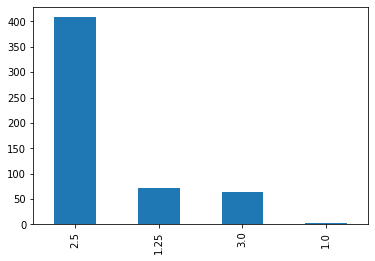

In [74]:
df.slice_thickness.value_counts().plot.bar()